# Independent Component Analysis and sEMG: Tutorial
Mattia Orlandi

In [1]:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import torch
from matplotlib import pyplot as plt
from scipy import signal

import emgkit

logging.basicConfig(level=logging.INFO)

if torch.cuda.is_available():
    device = torch.device("cuda")
    logging.info("Using CUDA version")
else:
    device = torch.device("cpu")
    logging.info("Using CPU version")

SIG_LEN = 4  # s
SIG_FS = 4000  # Hz
SNR = 20  # dB
SEED = 42

t = np.linspace(0, SIG_LEN, SIG_LEN * SIG_FS)
prng = np.random.default_rng(seed=SEED)

INFO:root:Using CUDA version


## Section 1 - ICA for Instantaneous Mixtures
Independent Component Analysis (ICA) is a method for separating independent sources from a mixture of signals.

### Data model
ICA is based on the following simple instantaneous mixing model:
$$x_i(t) = \sum_{j=1}^N a_{ij} s_j(t),\;\;\;\;i = 1, ..., M$$
where
- $x_i(t)$ is the $i$-th observation;
- $s_j(t)$ is the $j$-th source;
- $a_{ij}$ are the coefficients of the mixing matrix;
- $N$ is the number of sources;
- $M$ is the number of observations.

The model can be written in matrix form as:
$$\mathbf{x}(t) = \mathbf{A}\mathbf{s}(t)$$

In ICA, we treat each observation and source signal as a random variable, i.e., the value of a signal at time $t$ is a sample of the corresponding random variable; therefore, we can drop the time index $t$ and write the model as:
$$\mathbf{x} = \mathbf{A}\mathbf{s}$$
where $\mathbf{x}$ and $\mathbf{s}$ are, respectively, $M$- and $N$-dimensional random vectors.

### Assumptions and ambiguities
ICA aims at recovering the source signal $\mathbf{s}(t)$ from the observations $\mathbf{x}(t)$ only, and is based on the following assumptions:
1. The components must be _statistically independent_.
2. The components must be _non-gaussian_.

However, it has some ambiguities:
- the _order_ of the recovered components is arbitrary;
- the _scale and sign_ of the recovered components is arbitrary (unless we assume that the original components have unitary variance, which solves the ambiguity of the scale but leaves the ambiguity of the sign).

### Intuition
The Central Limit Theorem tells that the distribution of a sum of independent random variables tends towards a Gaussian distribution. Since the observed mixture is a weighted sum of the original components, its distribution will be closer to a Gaussian distribution than the distribution of the sources. Therefore, one can estimate one of the original component by _maximizing its non-gaussianity_.

### Measures of nongaussianity
To use nongaussianity in ICA, we need a quantitative measure of nongaussianity of a random variable $y$ (assumed to be zero-mean and to have a variance equal to one).

#### Kurtosis
The kurtosis of a zero-mean, unit-variance random variable $y$ is defined as:
$$\text{kurt}(y)=\mathbb{E}[y^4]-3$$

For a Gaussian variable, kurtosis is always zero; for non-gaussian variables, it is either positive or negative: distributions characterized by a positive kurtosis (e.g., sparse sequences) are referred to as _super-gaussian_ or _leptokurtic_, while those characterized by a negative kurtosis are called _sub-gaussian_ or _platykurtic_.

In ICA, we could compute the kurtosis of the component being estimated and follow the direction in which it increases the most (if it's positive) or decreases the most (if it's negative). However, kurtosis can be very sensitive to outliers, thus it's not a very robust measure of non-gaussianity.

#### Negentropy
The negentropy of a random variable $y$ is defined as:
$$J(y)=H(y_\text{gauss})-H(y)$$
where
- $y_\text{gauss}$ is a Gaussian random variable with the same covariance matrix as $y$;
- $H(\cdot)$ is entropy.

Since a Gaussian variable has the largest entropy among all random variables of equal variance, _negentropy is always positive_ and is zero iff the random variable is Gaussian.

The exact computation of negentropy is very difficult, and the following approximation is used in practice:
$$J(y)\propto\left(\mathbb{E}[G(y)]-\mathbb{E}[G(\nu)]\right)^2$$
where $\nu$ is a Gaussian variable of zero mean and unit variance, and $G(\cdot)$ is a non-quadratic function referred to as _contrast function_; common choices for $G$ are:
- $G(x)=\log\cosh(x)$;
- $G(x)=-\exp(-x^2/2)$;
- $G(x)=x^4/4$.

### Pre-processing for ICA
Before applying ICA algorithms to the data, some pre-processing is useful to simplify the estimation.

#### Centering
We subtract to vector $\mathbf{x}$ its mean vector to make $\mathbf{x}$ a zero-mean vector; this implies that the vector of original components $\mathbf{s}$ is zero-mean as well.

#### Whitening
After centering, we whiten the observations $\mathbf{x}$, namely we transform them so that they become uncorrelated and with variance equal to one; in other words, their covariance matrix becomes equal to the identity matrix:
$$\mathbb{E}[\mathbf{x}\mathbf{x}^\intercal]=\mathbf{I}$$

This procedure is very useful because the new separation matrix to be estimated is orthogonal, thus it has fewer degrees of freedom simplifying ICA.

There are two popular whitening methods: _PCA_ and _ZCA_.

##### PCA whitening
The covariance matrix $\mathbb{E}[\mathbf{x}\mathbf{x}^\intercal]$ is decomposed via eigenvalue decomposition, and the observations are whitened as follows:
$$\tilde{\mathbf{x}} = \mathbf{D}^{-1/2} \mathbf{E}^\intercal \mathbf{x}$$
where:
- $\mathbf{E}$ is the orthogonal matrix of eigenvectors;
- $\mathbf{D}$ is the diagonal matrix of eigenvalues.

By discarding the less important eigenvalues and eigenvectors, through PCA one can also reduce the dimension of the whitened observations (useful for instance when the number of sources is known, and it's less than the number of observations).

For regularization purposes, one can add a small factor (e.g., 1e-5) to each eigenvalue.

##### ZCA whitening
As for PCA, the covariance matrix $\mathbb{E}[\mathbf{x}\mathbf{x}^\intercal]$ is decomposed via eigenvalue decomposition, and the observations are whitened as follows:
$$\tilde{\mathbf{x}} = \mathbf{E} \mathbf{D}^{-1/2} \mathbf{E}^\intercal \mathbf{x}$$
namely it's almost equivalent to PCA with an additional rotation.

ZCA does not support dimensionality reduction, but it has the advantage of producing whitened observations that are as close as possible to the original ones.

For regularization purposes, one can add a small factor (e.g., 1e-5) to each eigenvalue.

### FastICA
FastICA is a Newton-like algorithm for ICA based on negentropy maximization. To avoid converging to the same source, one can enforce the estimated components to be uncorrelated; two strategies are possible:
- _deflation_: components are estimated one by one, and are progressively de-correlated using Gram-Schmidt de-correlation (less accurate since estimation errors accumulates, but more light-weight);
- _parallel_: components are estimated in parallel, and are de-correlated using symmetric de-correlation which is based on eigenvalue decomposition (more accurate since estimation errors spread evenly, but more expensive).

If the number of target sources is less than the number of observations, the mixture is said to be _undercomplete_; to address this, one can apply two approaches:
- reduce the dimensionality using PCA;
- reduce the dimensionality using FastICA itself.

Let's generate three dummy source signals.

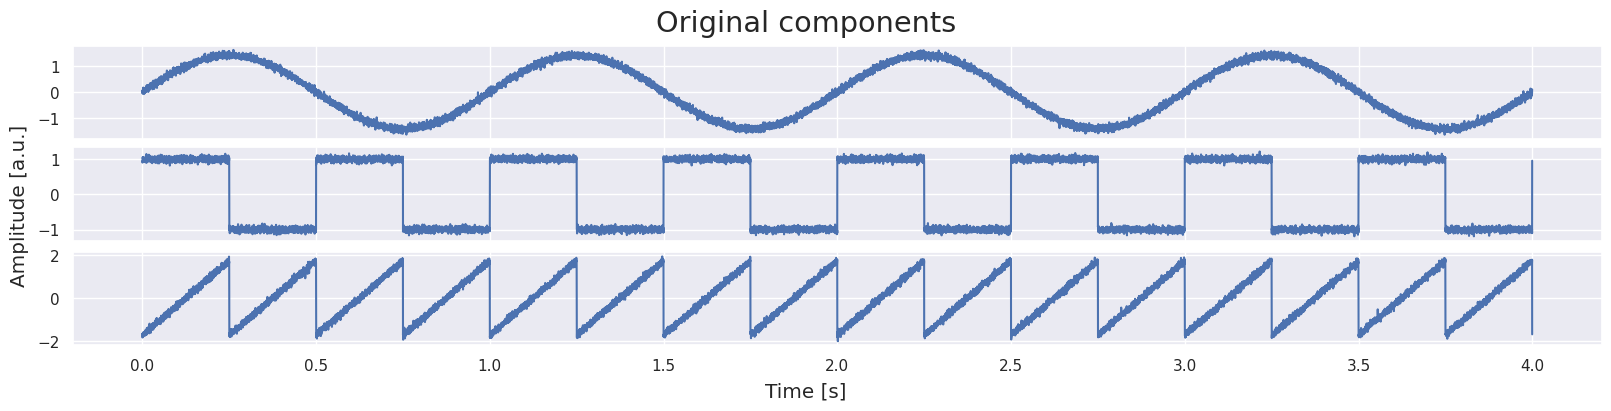

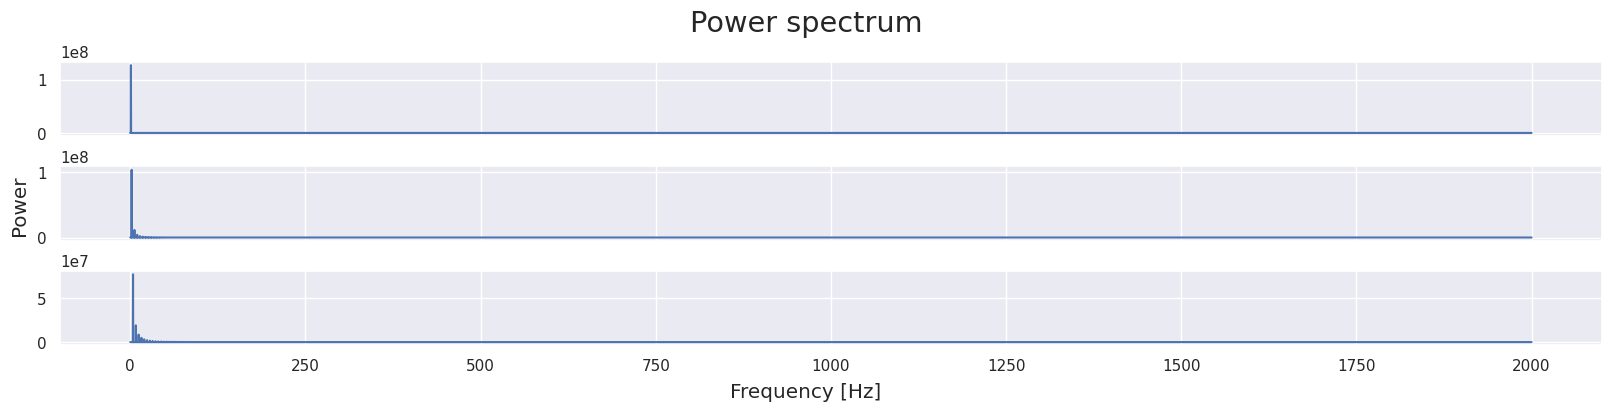

In [2]:
# Original components
S = np.stack(
    [
        np.sin(2 * np.pi * 1 * t),  # 1Hz
        signal.square(2 * np.pi * 2 * t),  # 2Hz
        signal.sawtooth(2 * np.pi * 4 * t),  # 4Hz
    ]
).T
# Introduce some randomness
S += prng.normal(scale=5e-2, size=S.shape)
# Force unitary variance
S = S / S.std(axis=0)
S = S.astype(np.float32)
n_samples, n_components = S.shape

emgkit.plotting.plot_signal(
    S,
    fs=SIG_FS,
    style="complete",
    title="Original components",
    fig_size=(16, 4),
)

# Compute power spectrum
S_power = emgkit.utils.power_spectrum(S, fs=SIG_FS)
emgkit.plotting.plot_signal(
    S_power,
    title="Power spectrum",
    x_label="Frequency [Hz]",
    y_label="Power",
    fig_size=(16, 4),
)

Let's check that they're uncorrelated.

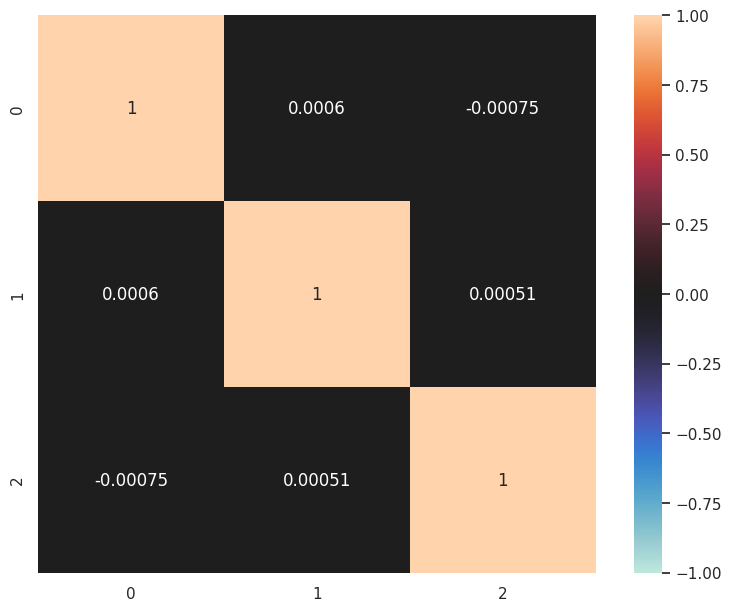

In [3]:
emgkit.plotting.plot_correlation(S, write_annotations=True, fig_size=(9, 6))

### Standard system ($N_T = M$)

#### Noiseless mixture
Let's generate a noiseless mixture of three observations.

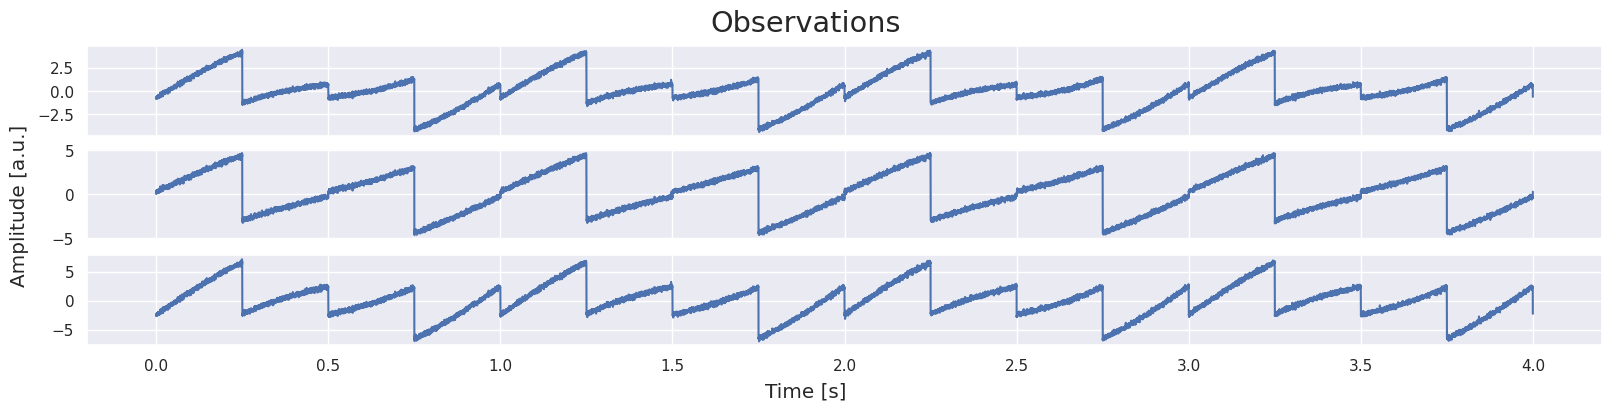

In [4]:
A = np.asarray(
    [
        [1.0, 1.0, 1.0],
        [0.5, 2.0, 1.0],
        [1.5, 1.0, 2.0],
    ],
    dtype=np.float32,
)  # 3x3 mixing matrix A

X = S @ A.T

emgkit.plotting.plot_signal(
    X, fs=SIG_FS, style="complete", title="Observations", fig_size=(16, 4)
)

Let's whiten the mixture, using either ZCA or PCA.

INFO:root:Instantiating ZCAWhitening using "svd" solver.


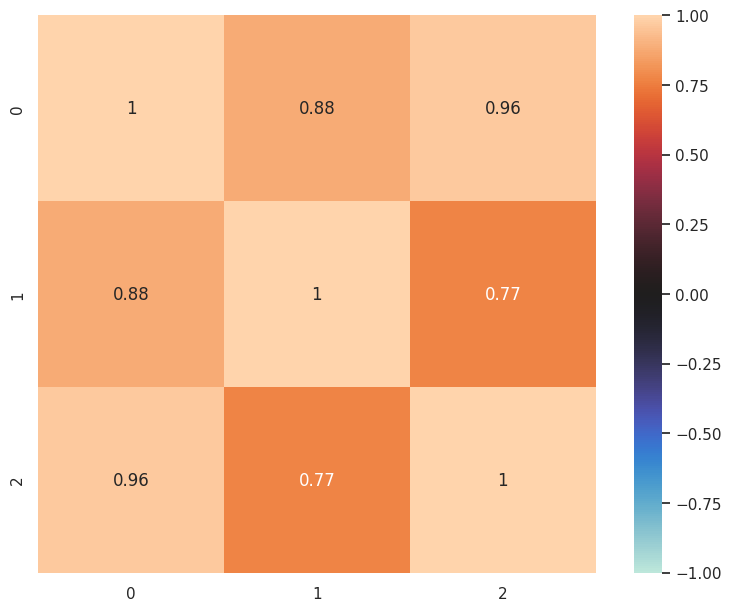

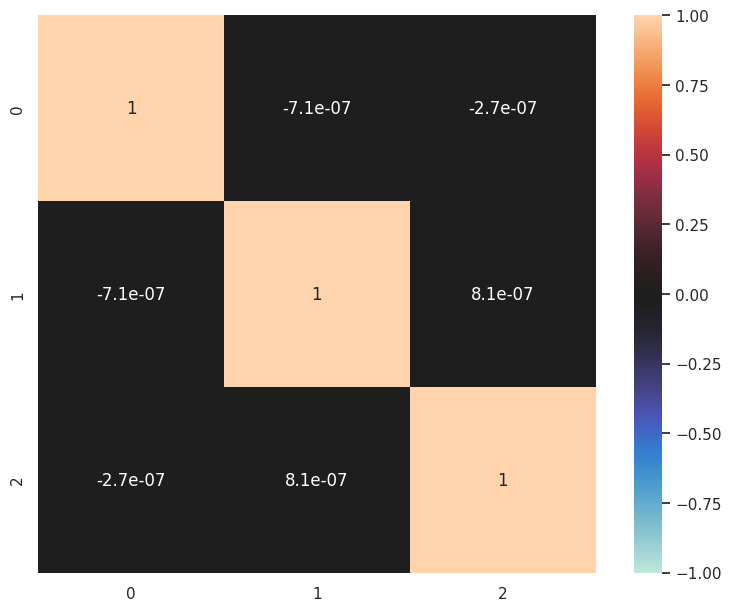

In [5]:
Xw, whiten_model = emgkit.preprocessing.zca_whitening(X, device=device)

emgkit.plotting.plot_correlation(X, write_annotations=True, fig_size=(9, 6))
emgkit.plotting.plot_correlation(Xw, write_annotations=True, fig_size=(9, 6))

Finally, let's run FastICA.

INFO:root:Instantiating FastICA using "symmetric" strategy and "logcosh" contrast function.
INFO:root:FastICA iteration 1: 9.508e-03.
INFO:root:FastICA iteration 2: 4.455e-03.
INFO:root:FastICA iteration 3: 1.056e-03.
INFO:root:FastICA iteration 4: 5.459e-04.


INFO:root:FastICA iteration 5: 1.256e-04.
INFO:root:FastICA iteration 6: 8.053e-05.
INFO:root:FastICA converged after 6 iterations, the distance is: 8.053e-05.
INFO:root:Performing saddle test...
INFO:root:Saddle point test ok.


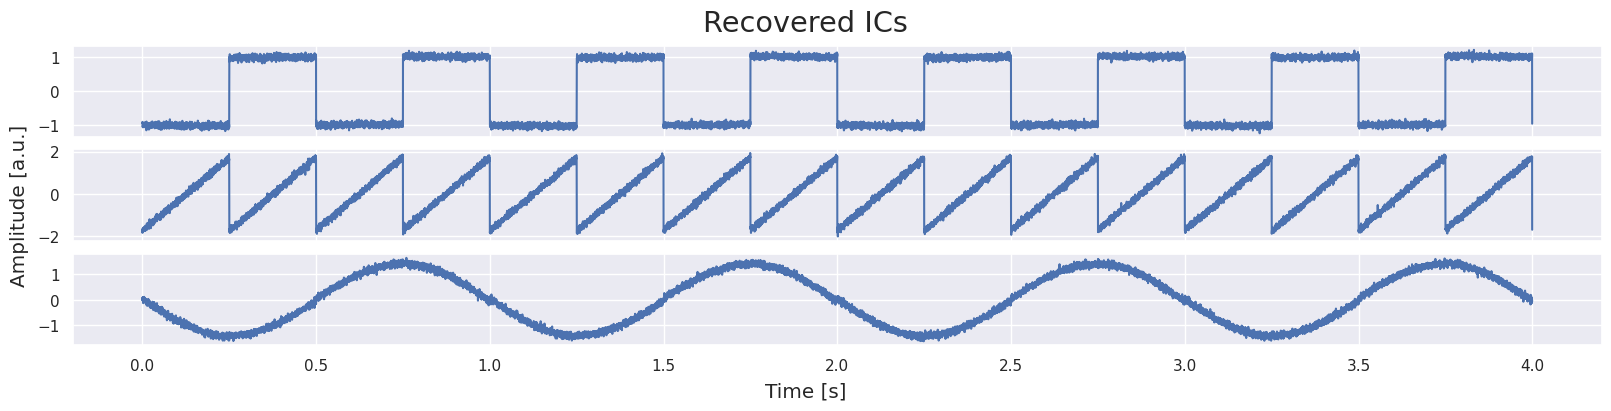

In [6]:
# Initial weights
w_init3x3 = torch.from_numpy(prng.standard_normal(size=(3, 3), dtype=np.float32)).to(
    device
)

S_rec, ica_model = emgkit.ica.fast_ica(
    Xw,
    whiten_alg="none",
    do_saddle_test=True,
    device=device,
    w_init=w_init3x3,
)

emgkit.plotting.plot_signal(
    S_rec, fs=SIG_FS, style="complete", title="Recovered ICs", fig_size=(16, 4)
)

#### Noisy mixture
Now let's add some noise to the mixture with the given SNR.

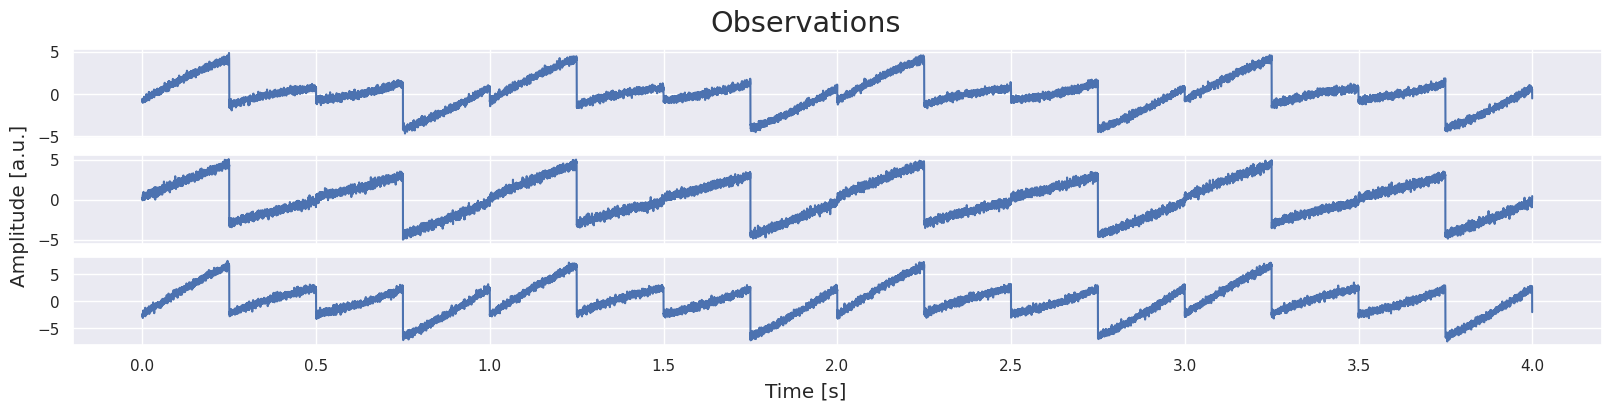

In [7]:
n_channels = X.shape[1]

# Compute signal power and convert to dB
X_avg_power = np.mean(np.square(X), axis=0)
X_avg_db = 10 * np.log10(X_avg_power)
# Compute noise power
noise_avg_db = X_avg_db - SNR
noise_avg_power = 10 ** (noise_avg_db / 10)

# Generate white Gaussian noise with given power
noise = np.zeros_like(X)
for i in range(n_channels):  # iterate over channels
    noise[:, i] = prng.standard_normal(n_samples, dtype=np.float32)
    noise[:, i] *= np.sqrt(noise_avg_power[i])
X += noise

emgkit.plotting.plot_signal(
    X, fs=SIG_FS, style="complete", title="Observations", fig_size=(16, 4)
)

Let's apply a low-pass filter on the noisy mixture.

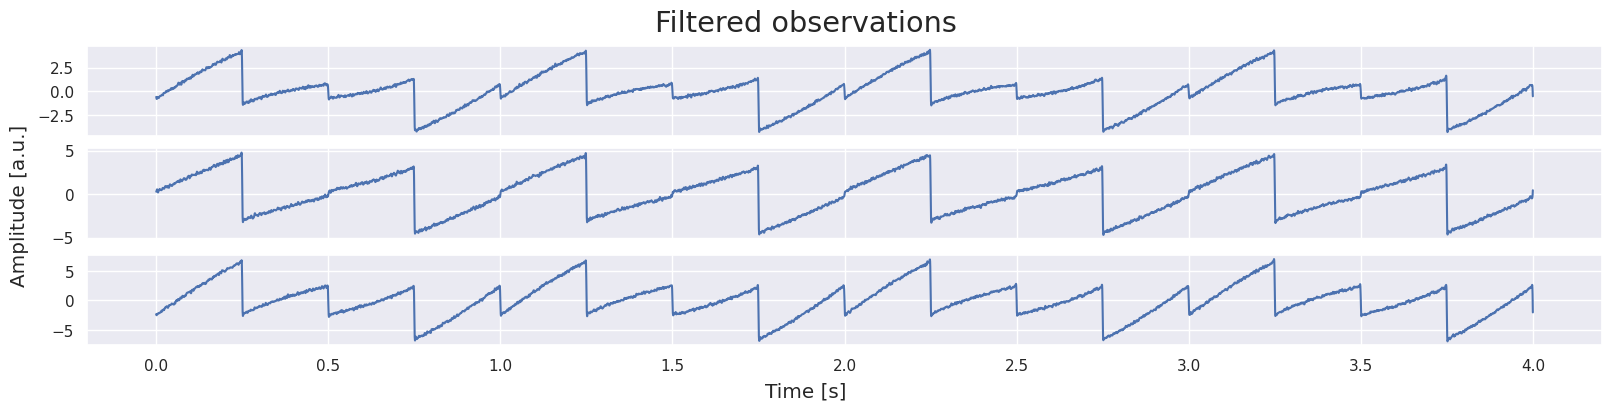

In [8]:
# Filter signal
Xf = emgkit.preprocessing.lowpass_filter(X, cut=250, fs=SIG_FS)

emgkit.plotting.plot_signal(
    Xf, fs=SIG_FS, style="complete", title="Filtered observations", fig_size=(16, 4)
)

Let's whiten the mixture, using either ZCA or PCA.

INFO:root:Instantiating ZCAWhitening using "svd" solver.


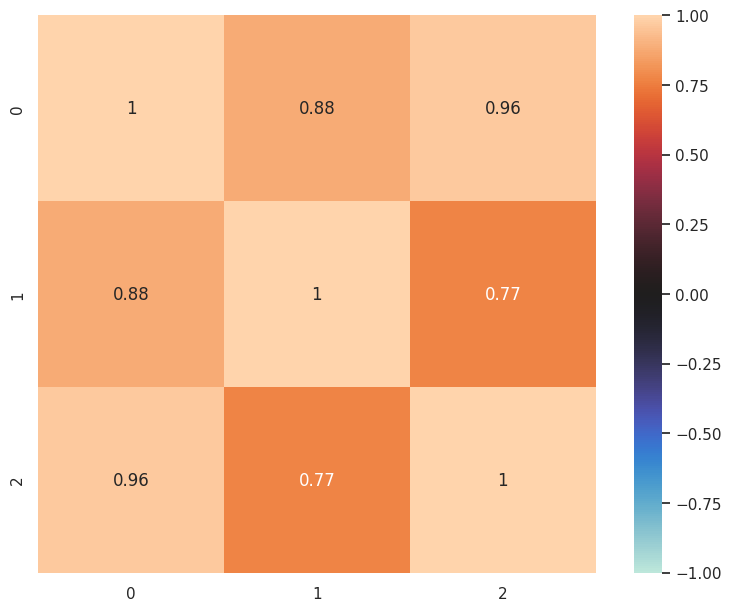

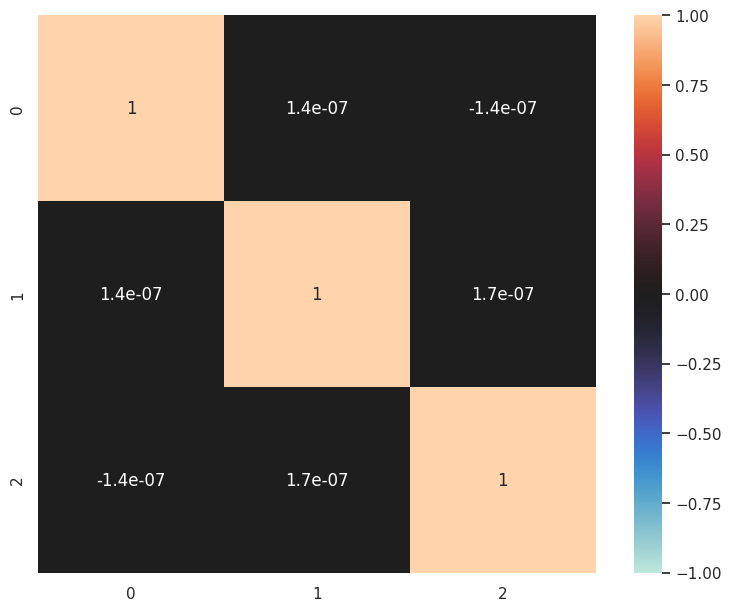

In [9]:
Xw, whiten_model = emgkit.preprocessing.zca_whitening(Xf, device=device)

emgkit.plotting.plot_correlation(Xf, write_annotations=True, fig_size=(9, 6))
emgkit.plotting.plot_correlation(Xw, write_annotations=True, fig_size=(9, 6))

Finally, let's run FastICA.

INFO:root:Instantiating FastICA using "symmetric" strategy and "logcosh" contrast function.
INFO:root:FastICA iteration 1: 9.863e-03.
INFO:root:FastICA iteration 2: 3.898e-03.
INFO:root:FastICA iteration 3: 9.043e-04.
INFO:root:FastICA iteration 4: 3.819e-04.
INFO:root:FastICA iteration 5: 8.279e-05.
INFO:root:FastICA converged after 5 iterations, the distance is: 8.279e-05.
INFO:root:Performing saddle test...


INFO:root:Saddle point test ok.


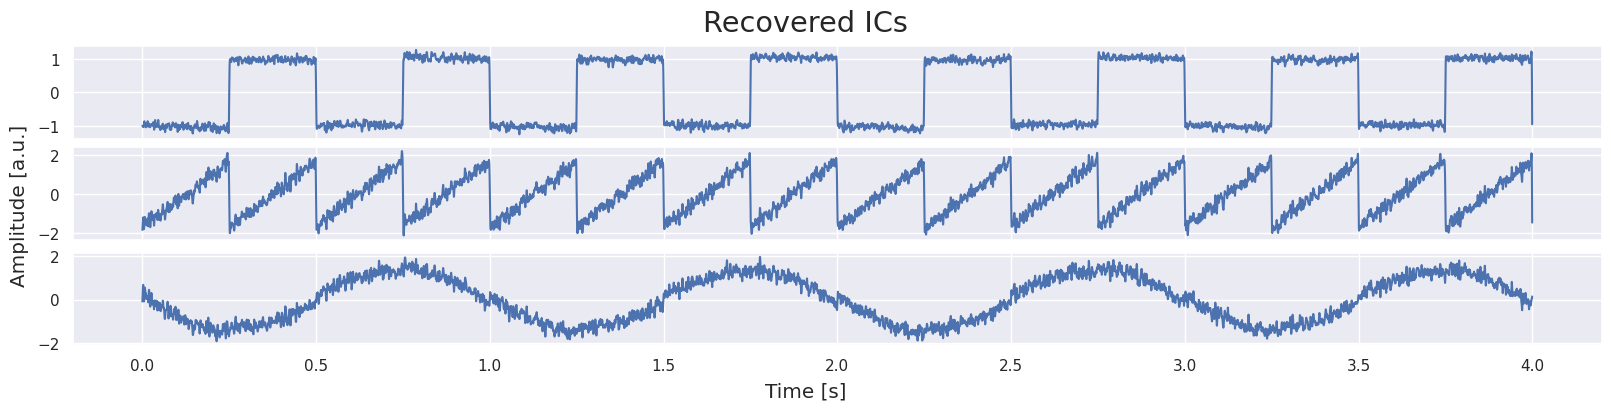

In [10]:
S_rec, ica_model = emgkit.ica.fast_ica(
    Xw,
    whiten_alg="none",
    do_saddle_test=True,
    device=device,
    w_init=w_init3x3,
)

emgkit.plotting.plot_signal(
    S_rec, fs=SIG_FS, style="complete", title="Recovered ICs", fig_size=(16, 4)
)

### Undercomplete system ($N_T < M$)

#### Noiseless mixture
Let's generate a noiseless mixture of four observations.

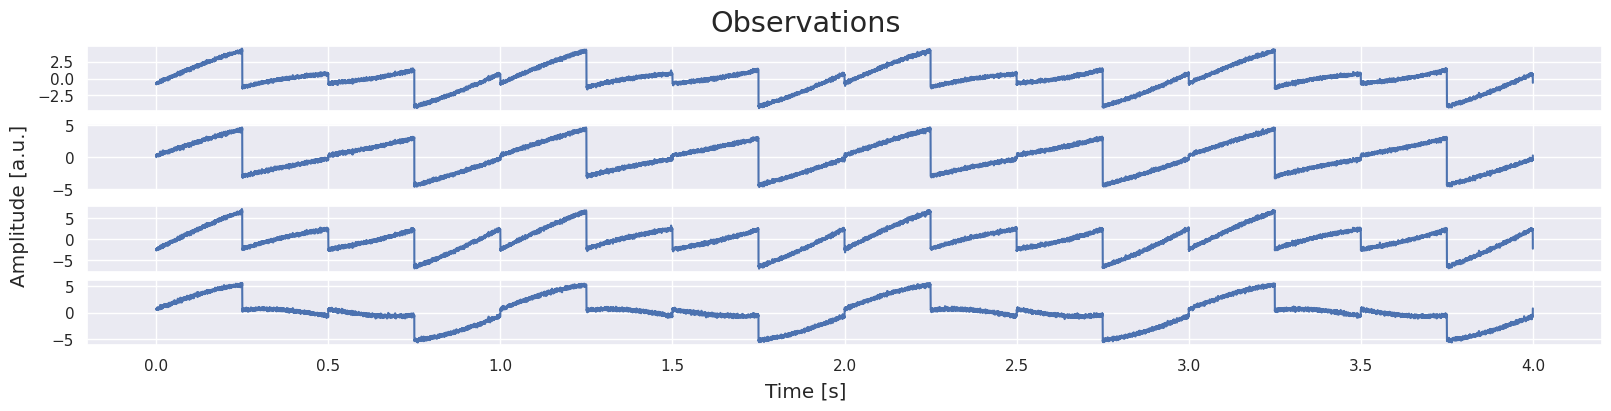

In [11]:
A = np.asarray(
    [
        [1.0, 1.0, 1.0],
        [0.5, 2.0, 1.0],
        [1.5, 1.0, 2.0],
        [2.0, 1.5, 0.5],
    ],
    dtype=np.float32,
)  # 4x3 mixing matrix A

X = S @ A.T

emgkit.plotting.plot_signal(
    X, fs=SIG_FS, style="complete", title="Observations", fig_size=(16, 4)
)

##### Reducing dimensionality with PCA
Since the mixture is now undercomplete, we reduce the dimensionality of the observations to three using PCA.

INFO:root:Instantiating PCAWhitening using "svd" solver.
INFO:root:Reducing dimension of data from 4 to 3.


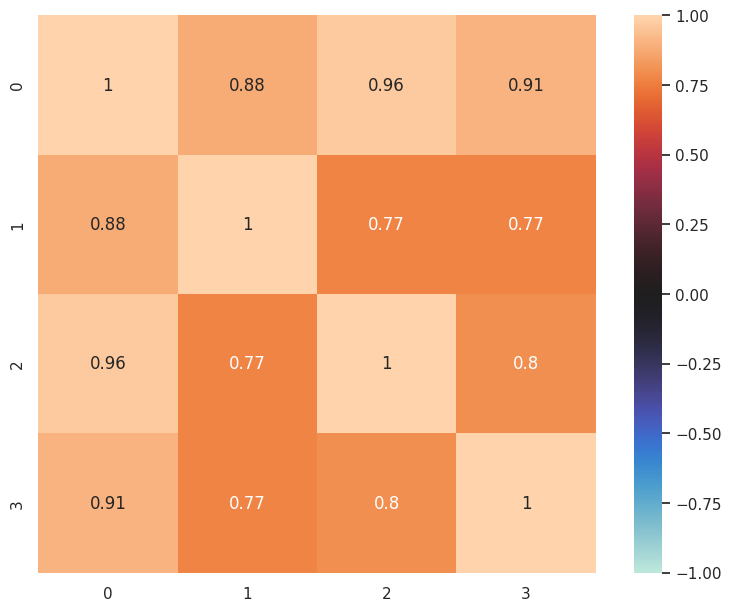

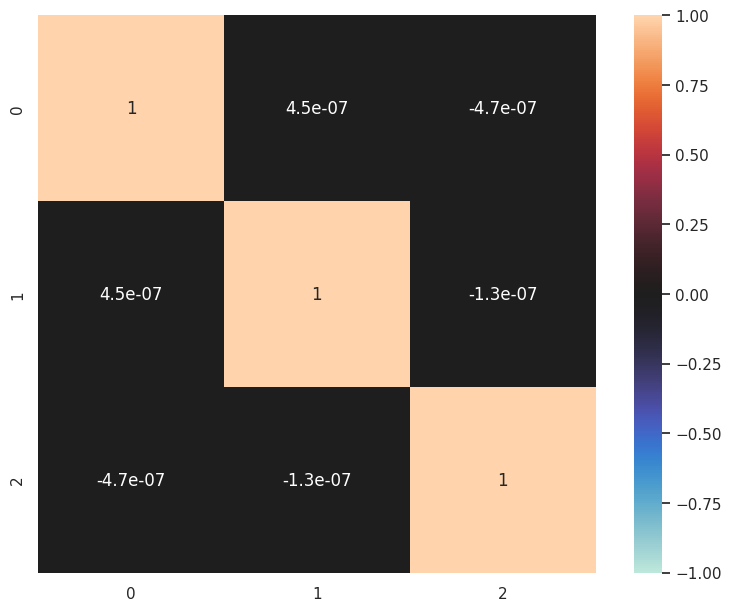

In [12]:
Xw, whiten_model = emgkit.preprocessing.pca_whitening(X, n_pcs=3, device=device)

emgkit.plotting.plot_correlation(X, write_annotations=True, fig_size=(9, 6))
emgkit.plotting.plot_correlation(Xw, write_annotations=True, fig_size=(9, 6))

Finally, let's run FastICA.

INFO:root:Instantiating FastICA using "symmetric" strategy and "logcosh" contrast function.
INFO:root:FastICA iteration 1: 6.831e-02.
INFO:root:FastICA iteration 2: 1.388e-02.
INFO:root:FastICA iteration 3: 1.099e-02.
INFO:root:FastICA iteration 4: 2.590e-03.
INFO:root:FastICA iteration 5: 1.704e-03.
INFO:root:FastICA iteration 6: 5.990e-04.
INFO:root:FastICA iteration 7: 3.670e-04.
INFO:root:FastICA iteration 8: 1.630e-04.
INFO:root:FastICA iteration 9: 9.847e-05.
INFO:root:FastICA converged after 9 iterations, the distance is: 9.847e-05.
INFO:root:Performing saddle test...


INFO:root:Saddle point test ok.


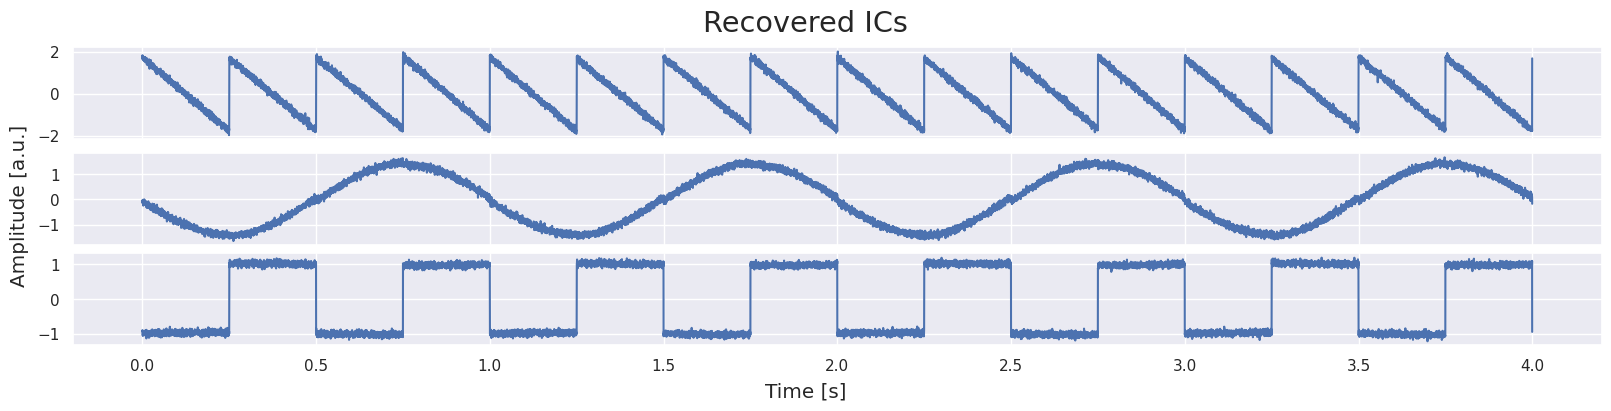

In [13]:
S_rec, ica_model = emgkit.ica.fast_ica(
    Xw,
    whiten_alg="none",
    do_saddle_test=True,
    device=device,
    w_init=w_init3x3,
)

emgkit.plotting.plot_signal(
    S_rec, fs=SIG_FS, style="complete", title="Recovered ICs", fig_size=(16, 4)
)

##### Reducing dimensionality with FastICA
Alternatively, we can reduce the dimensionality using FastICA itself.

Let's whiten the observations using ZCA.

INFO:root:Instantiating ZCAWhitening using "svd" solver.


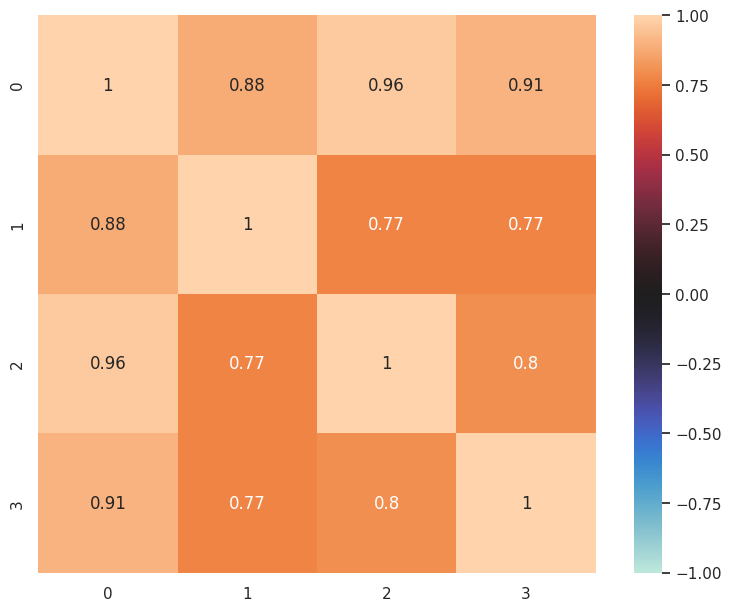

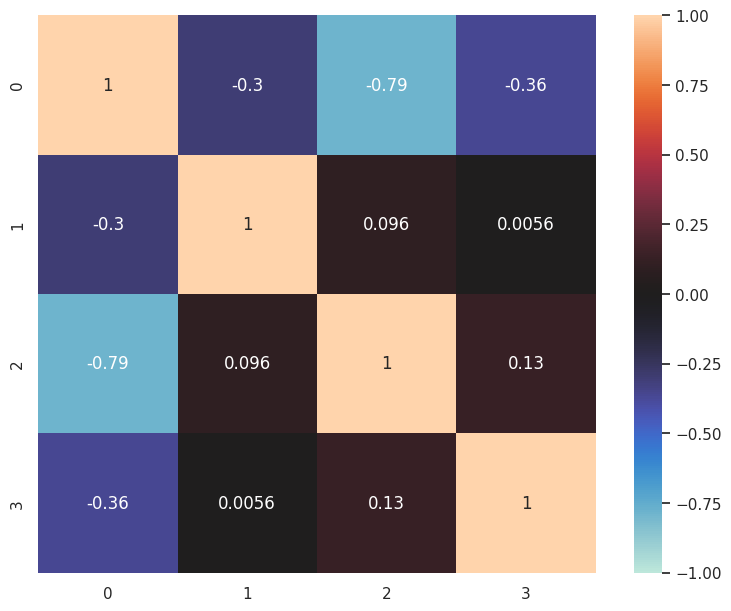

In [14]:
Xw, whiten_model = emgkit.preprocessing.zca_whitening(X, device=device)

emgkit.plotting.plot_correlation(X, write_annotations=True, fig_size=(9, 6))
emgkit.plotting.plot_correlation(Xw, write_annotations=True, fig_size=(9, 6))

Noteworthily, the whitening fails due to the fact that the matrix describing the mixture is not full rank.

Let's run FastICA.

INFO:root:Instantiating FastICA using "symmetric" strategy and "logcosh" contrast function.
INFO:root:FastICA iteration 1: 8.276e-01.
INFO:root:FastICA iteration 2: 4.632e-02.
INFO:root:FastICA iteration 3: 1.409e-02.
INFO:root:FastICA iteration 4: 6.151e-03.
INFO:root:FastICA iteration 5: 3.055e-03.
INFO:root:FastICA iteration 6: 1.537e-03.
INFO:root:FastICA iteration 7: 7.748e-04.
INFO:root:FastICA iteration 8: 4.125e-04.
INFO:root:FastICA iteration 9: 2.377e-04.
INFO:root:FastICA iteration 10: 1.420e-04.
INFO:root:FastICA iteration 11: 8.982e-05.
INFO:root:FastICA converged after 11 iterations, the distance is: 8.982e-05.
INFO:root:Performing saddle test...
INFO:root:Saddle point test ok.


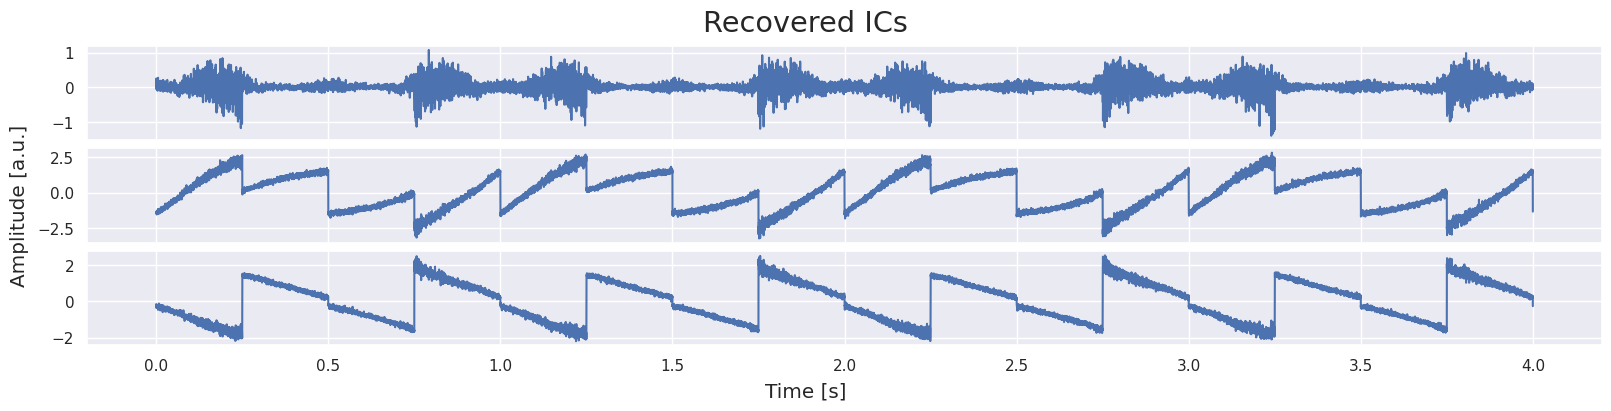

In [15]:
# Initial weights
w_init3x4 = torch.from_numpy(prng.standard_normal(size=(3, 4), dtype=np.float32)).to(
    device
)

S_rec = emgkit.ica.fast_ica(
    Xw,
    n_ics=3,
    whiten_alg="none",
    do_saddle_test=True,
    device=device,
    w_init=w_init3x4,
)[0]

emgkit.plotting.plot_signal(
    S_rec, fs=SIG_FS, style="complete", title="Recovered ICs", fig_size=(16, 4)
)

As expected, FastICA also fails.

#### Noisy mixture
Now let's add some noise to the mixture with the given SNR.

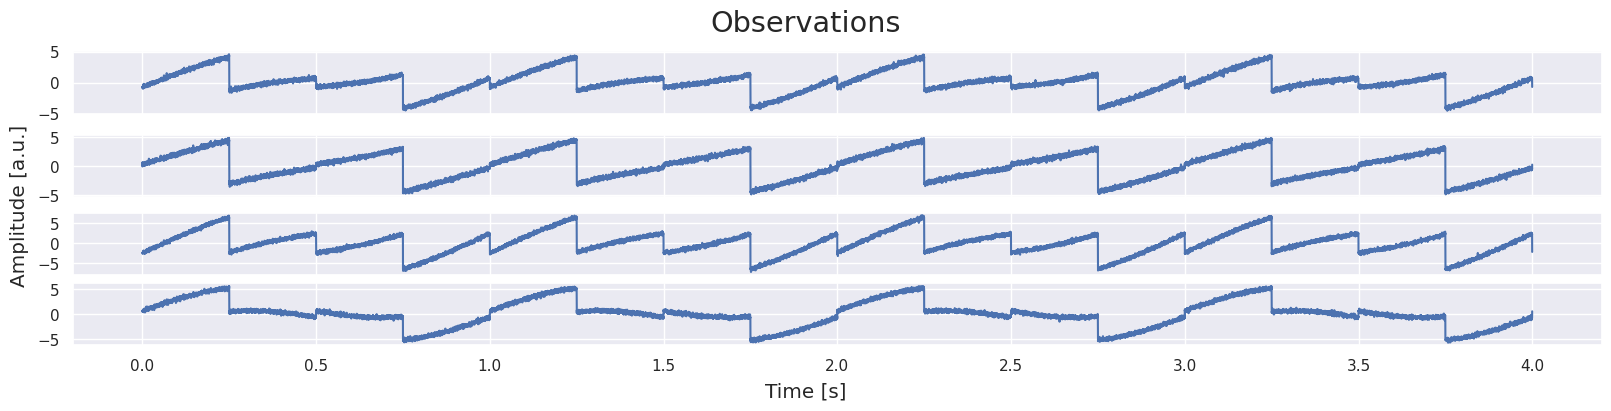

In [16]:
n_channels = X.shape[1]

# Compute signal power and convert to dB
X_avg_power = np.mean(np.square(X), axis=1)
X_avg_db = 10 * np.log10(X_avg_power)
# Compute noise power
noise_avg_db = X_avg_db - SNR
noise_avg_power = 10 ** (noise_avg_db / 10)

# Generate white Gaussian noise with given power
noise = np.zeros_like(X)
for i in range(n_channels):  # iterate over channels
    noise[:, i] = prng.standard_normal(n_samples, dtype=np.float32)
    noise[:, i] *= np.sqrt(noise_avg_power[i])
X += noise

emgkit.plotting.plot_signal(
    X, fs=SIG_FS, style="complete", title="Observations", fig_size=(16, 4)
)

Let's apply a low-pass filter on the noisy mixture.

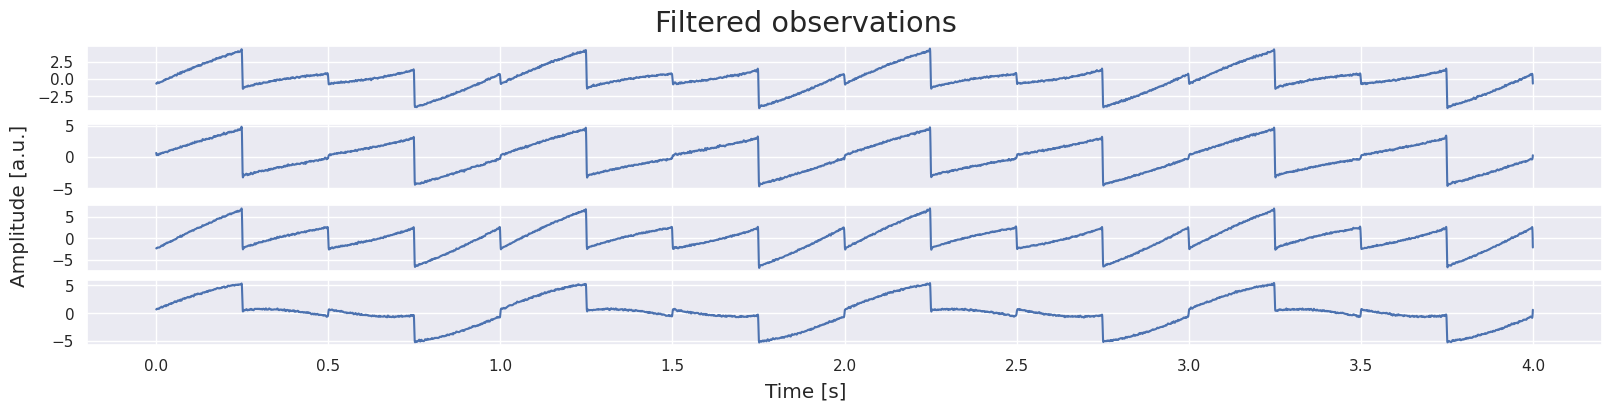

In [17]:
# Filter signal
Xf = emgkit.preprocessing.lowpass_filter(X, cut=250, fs=SIG_FS)

emgkit.plotting.plot_signal(
    Xf, fs=SIG_FS, style="complete", title="Filtered observations", fig_size=(16, 4)
)

##### Reducing dimensionality with PCA
As before, we can reduce the dimensionality of the observations to three using PCA.

INFO:root:Instantiating PCAWhitening using "svd" solver.
INFO:root:Reducing dimension of data from 4 to 3.


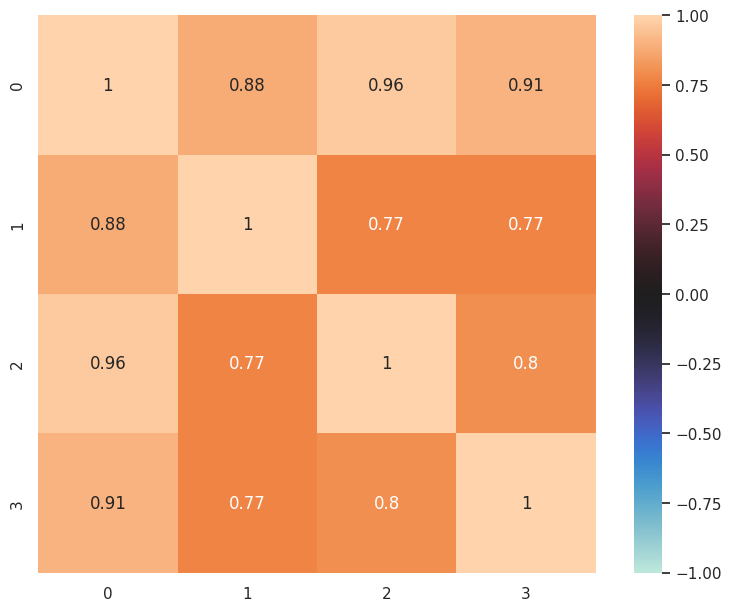

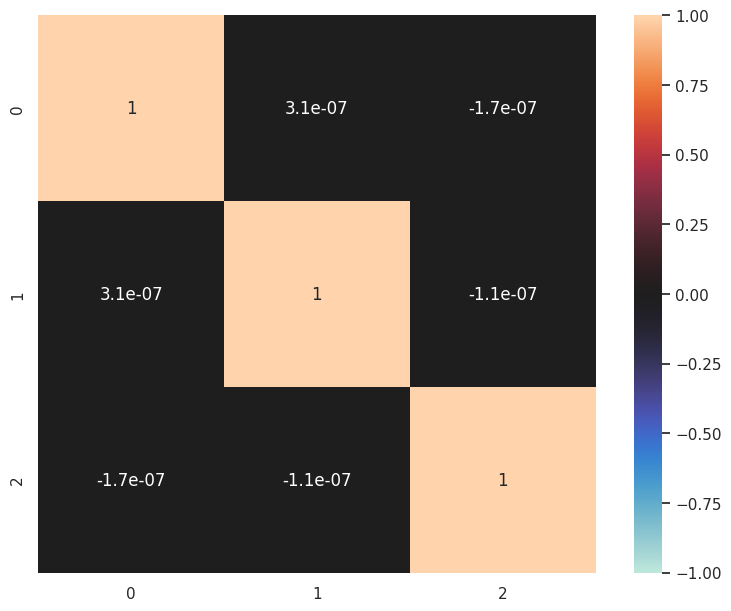

In [18]:
Xw, whiten_model = emgkit.preprocessing.pca_whitening(Xf, n_pcs=3, device=device)

emgkit.plotting.plot_correlation(Xf, write_annotations=True, fig_size=(9, 6))
emgkit.plotting.plot_correlation(Xw, write_annotations=True, fig_size=(9, 6))

Finally, let's run FastICA.

INFO:root:Instantiating FastICA using "symmetric" strategy and "logcosh" contrast function.
INFO:root:FastICA iteration 1: 5.289e-02.
INFO:root:FastICA iteration 2: 1.195e-02.
INFO:root:FastICA iteration 3: 1.046e-02.
INFO:root:FastICA iteration 4: 6.115e-03.
INFO:root:FastICA iteration 5: 3.040e-03.
INFO:root:FastICA iteration 6: 1.142e-03.
INFO:root:FastICA iteration 7: 6.010e-04.
INFO:root:FastICA iteration 8: 2.877e-04.
INFO:root:FastICA iteration 9: 1.620e-04.
INFO:root:FastICA iteration 10: 8.428e-05.
INFO:root:FastICA converged after 10 iterations, the distance is: 8.428e-05.
INFO:root:Performing saddle test...
INFO:root:Saddle point test ok.


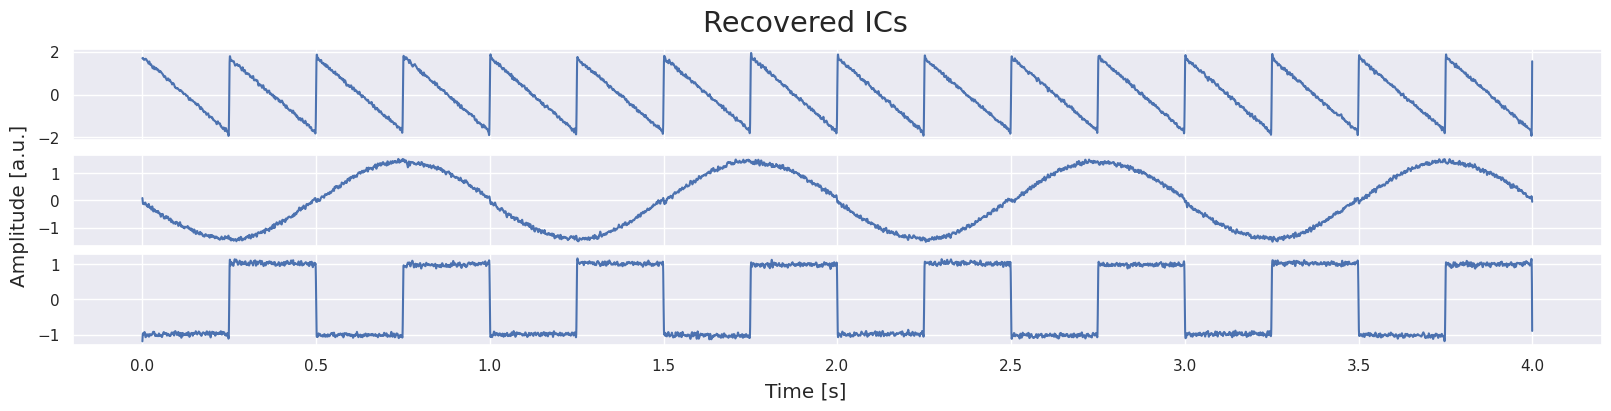

In [19]:
S_rec, ica_model = emgkit.ica.fast_ica(
    Xw,
    whiten_alg="none",
    do_saddle_test=True,
    device=device,
    w_init=w_init3x3,
)

emgkit.plotting.plot_signal(
    S_rec, fs=SIG_FS, style="complete", title="Recovered ICs", fig_size=(16, 4)
)

##### Reducing dimensionality with FastICA
Let's try again to reduce the dimensionality via FastICA itself.

Let's whiten the observations using ZCA.

INFO:root:Instantiating ZCAWhitening using "svd" solver.


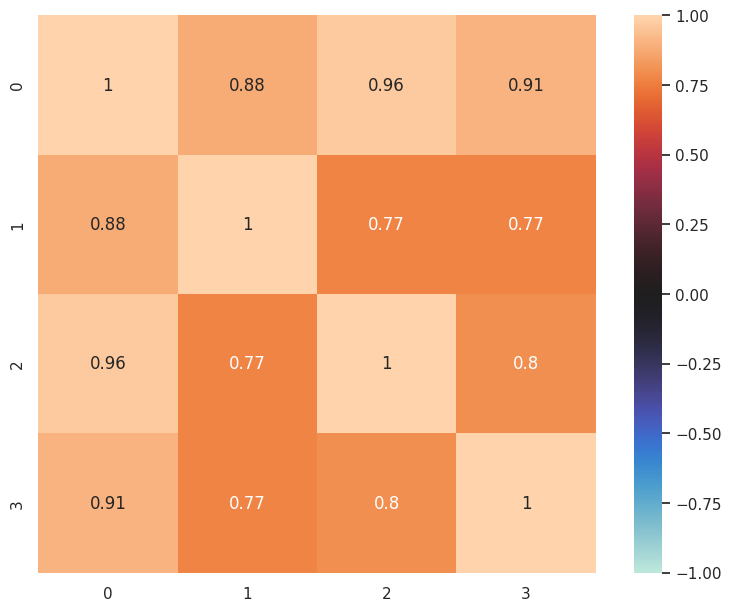

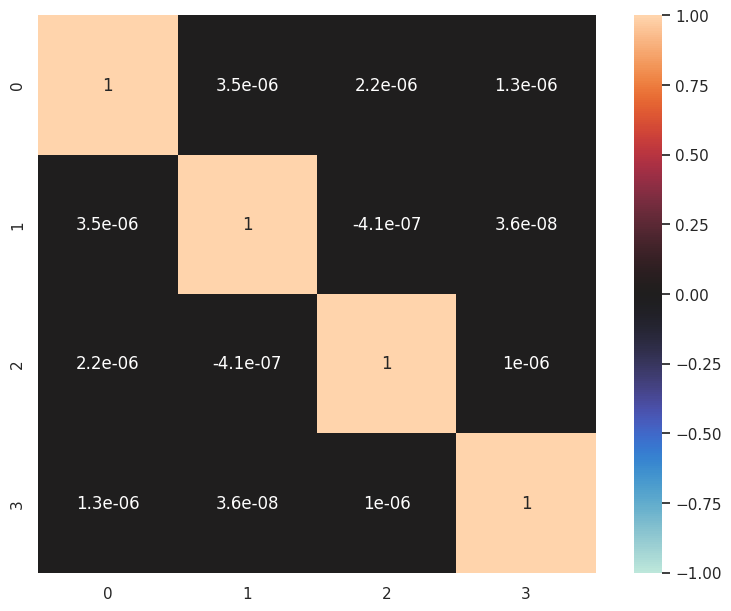

In [20]:
Xw, whiten_model = emgkit.preprocessing.zca_whitening(Xf, device=device)

emgkit.plotting.plot_correlation(Xf, write_annotations=True, fig_size=(9, 6))
emgkit.plotting.plot_correlation(Xw, write_annotations=True, fig_size=(9, 6))

This time whitening worked, because the matrix is now full rank (thanks to the added noise).

Let's run FastICA.

INFO:root:Instantiating FastICA using "symmetric" strategy and "logcosh" contrast function.
INFO:root:FastICA iteration 1: 5.796e-01.
INFO:root:FastICA iteration 2: 1.741e-01.
INFO:root:FastICA iteration 3: 2.550e-01.
INFO:root:FastICA iteration 4: 3.645e-01.
INFO:root:FastICA iteration 5: 1.188e-01.
INFO:root:FastICA iteration 6: 1.297e-01.
INFO:root:FastICA iteration 7: 1.390e-01.
INFO:root:FastICA iteration 8: 1.403e-01.
INFO:root:FastICA iteration 9: 1.628e-01.
INFO:root:FastICA iteration 10: 1.866e-01.
INFO:root:FastICA iteration 11: 2.014e-01.
INFO:root:FastICA iteration 12: 2.658e-01.
INFO:root:FastICA iteration 13: 2.069e-01.
INFO:root:FastICA iteration 14: 1.574e-01.
INFO:root:FastICA iteration 15: 1.445e-01.
INFO:root:FastICA iteration 16: 1.060e-01.
INFO:root:FastICA iteration 17: 8.924e-02.
INFO:root:FastICA iteration 18: 6.398e-02.
INFO:root:FastICA iteration 19: 4.425e-02.
INFO:root:FastICA iteration 20: 2.558e-02.
INFO:root:FastICA iteration 21: 1.368e-02.
INFO:root:Fast

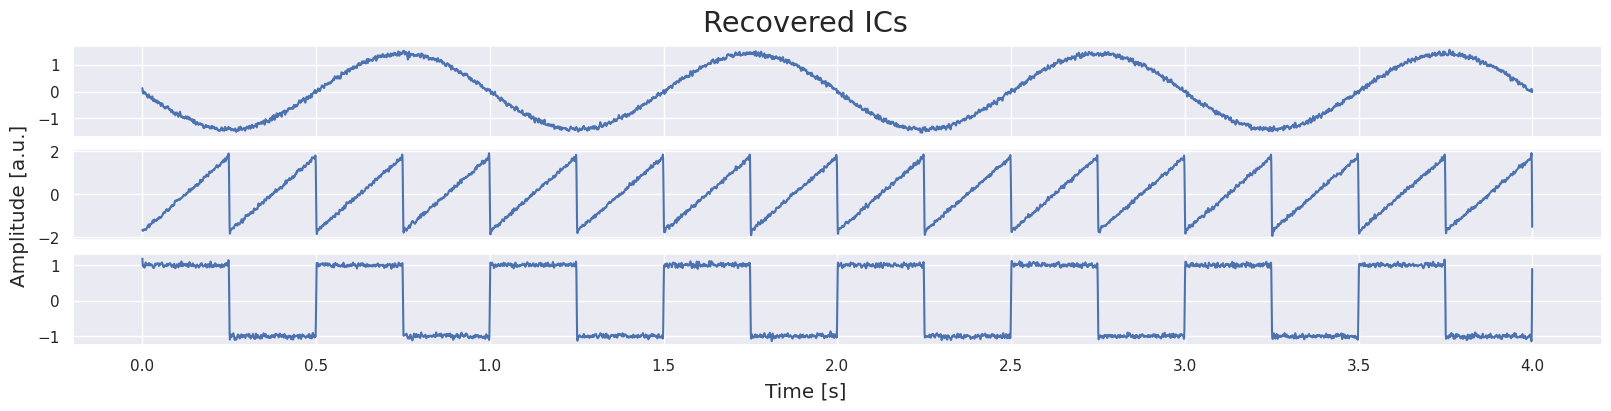

In [21]:
S_rec, ica_model = emgkit.ica.fast_ica(
    Xw,
    n_ics=3,
    whiten_alg="none",
    do_saddle_test=True,
    device=device,
    w_init=w_init3x4,
)

emgkit.plotting.plot_signal(
    S_rec, fs=SIG_FS, style="complete", title="Recovered ICs", fig_size=(16, 4)
)

### Correlated components
As a counter-example, let's try to separate a mixture of correlated components.

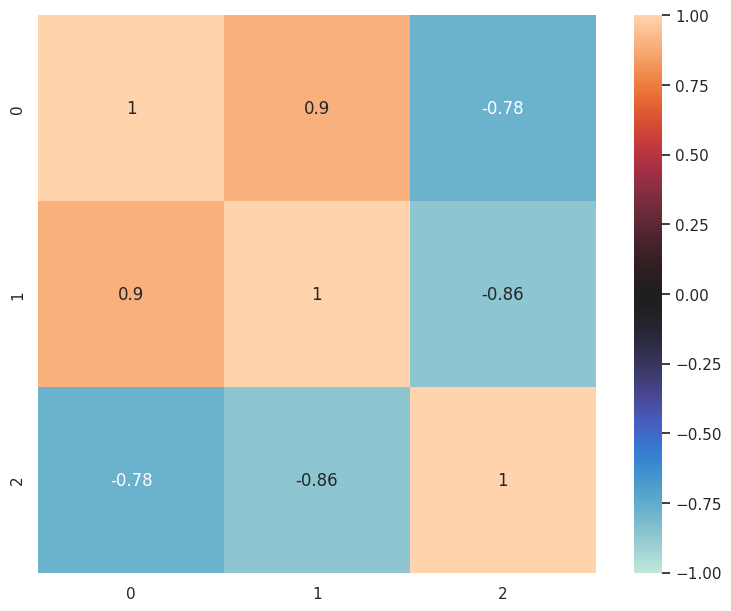

In [22]:
# Original components
S = np.stack(
    [
        np.sin(2 * np.pi * 1 * t),  # 1Hz
        signal.square(2 * np.pi * 1 * t),  # 1Hz
        signal.sawtooth(2 * np.pi * 1 * t),  # 1Hz
    ]
).T
# Introduce some randomness
S += prng.normal(scale=5e-2, size=S.shape)
# Force unitary variance
S = S / S.std(axis=0)
S = S.astype(np.float32)
n_samples, n_components = S.shape

emgkit.plotting.plot_correlation(S, write_annotations=True, fig_size=(9, 6))

INFO:root:Instantiating FastICA using "symmetric" strategy and "logcosh" contrast function.
INFO:root:Instantiating ZCAWhitening using "svd" solver.
INFO:root:FastICA iteration 1: 1.060e-02.
INFO:root:FastICA iteration 2: 2.861e-03.
INFO:root:FastICA iteration 3: 8.578e-04.
INFO:root:FastICA iteration 4: 3.797e-04.
INFO:root:FastICA iteration 5: 1.416e-04.
INFO:root:FastICA iteration 6: 7.385e-05.
INFO:root:FastICA converged after 6 iterations, the distance is: 7.385e-05.
INFO:root:Performing saddle test...
INFO:root:Saddle point test ok.


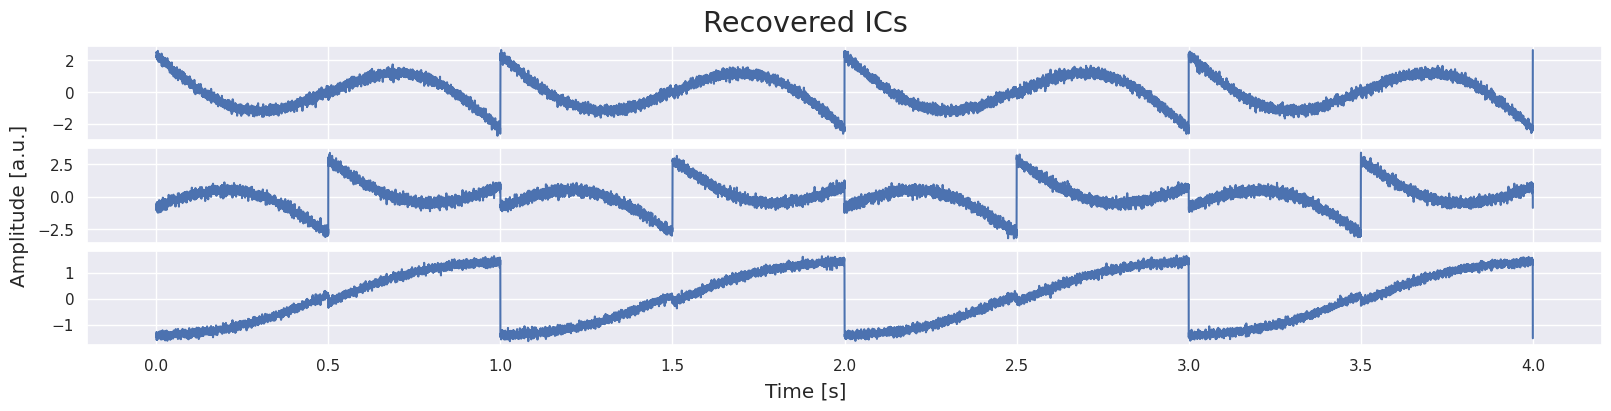

In [23]:
A = np.asarray(
    [
        [1.0, 1.0, 1.0],
        [0.5, 2.0, 1.0],
        [1.5, 1.0, 2.0],
    ],
    dtype=np.float32,
)  # 3x3 mixing matrix A

X = S @ A.T

# Whitening + FastICA
S_rec, ica_model = emgkit.ica.fast_ica(X, do_saddle_test=True, device=device)

emgkit.plotting.plot_signal(
    S_rec,
    fs=SIG_FS,
    style="complete",
    title="Recovered ICs",
    fig_size=(16, 4),
)

As expected, FastICA fails.

## Section 2 - ICA for Blind Deconvolution
In a real-world scenario (such as in EMG decomposition), mixing processes are not instantaneous: the environment imposes a different impulse response between each source and each receiver pair, resulting in a convolutive mixture:
$$x_i(t)=\sum_{j=1}^N \sum_\tau a_{ij}(\tau)s_j(t-\tau)\;\;\;\;i=1,...,M$$
where:
- $x_i(t)$ is the $i$-th observation;
- $s_j(t)$ is the $j$-th source;
- $a_{ij}(\tau)$ are the coefficients of the mixing filter;
- $N$ is the number of sources;
- $M$ is the number of observations.

By choosing a sufficiently large extension factor $f_\text{ext}$ and by stacking multiple delayed replicas of sources and observations, one can express the convolutive mixture as an instantaneous mixture, which can be addressed by ICA. Due to the extension step, an additional assumption must be made:
1. The components must be _uncorrelated_.
2. The components must be _non-gaussian_.
3. Each component should _not be auto-correlated_.

If we consider a sparse source, assumptions (2) and (3) are satisfied:
- sparse sources can be modeled as _leptokurtic_ random variables, thus they're non-gaussian;
- sparse sources tend not to be auto-correlated.

For simplicity, let's consider a convolutive mixture of a single sparse component and try to recover it (a task referred to as _blind deconvolution_).

Let's generate a sparse source.

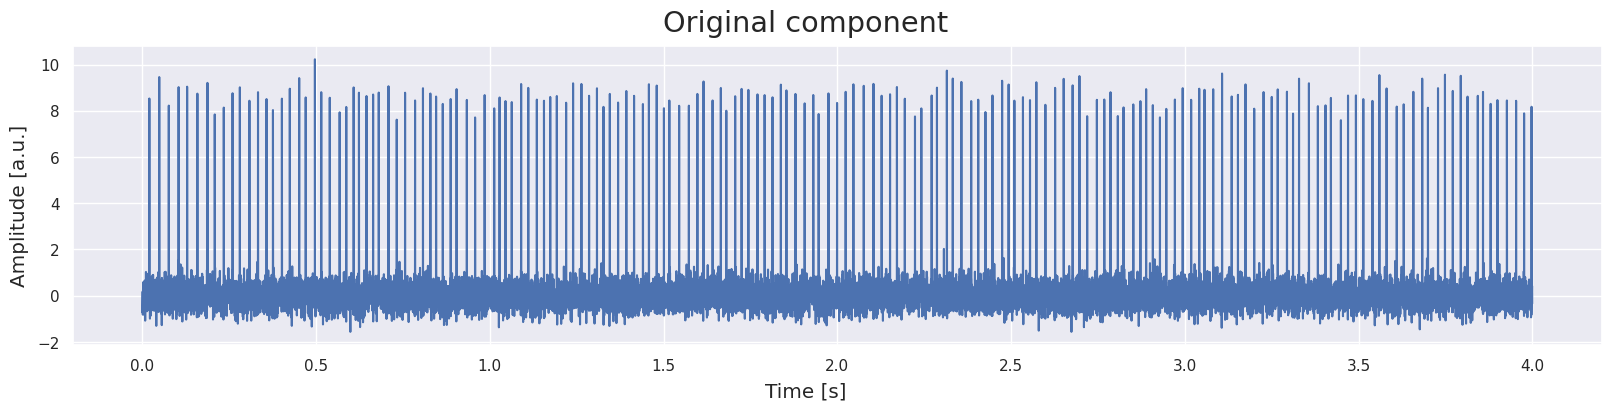

In [24]:
# Generate pulse indexes
ref_period = int(round(15e-3 * SIG_FS))  # refractory period (15ms)

idx = []
last_idx = 0
while True:
    cur_idx = prng.integers(low=last_idx + ref_period, high=last_idx + 2 * ref_period)
    if cur_idx >= n_samples:
        break
    idx.append(cur_idx)
    last_idx = cur_idx
# Generate signal
S = signal.unit_impulse(shape=(SIG_LEN * SIG_FS,), idx=idx)
# Introduce some randomness
S += prng.normal(scale=5e-2, size=S.shape)
# Force unitary variance
S /= S.std()
S = S.astype(np.float32)

emgkit.plotting.plot_signal(
    S, fs=SIG_FS, style="complete", title="Original component", fig_size=(16, 4)
)

Let's generate the convolutive mixture by convolving a random kernel with the source.

Kernel length: 80


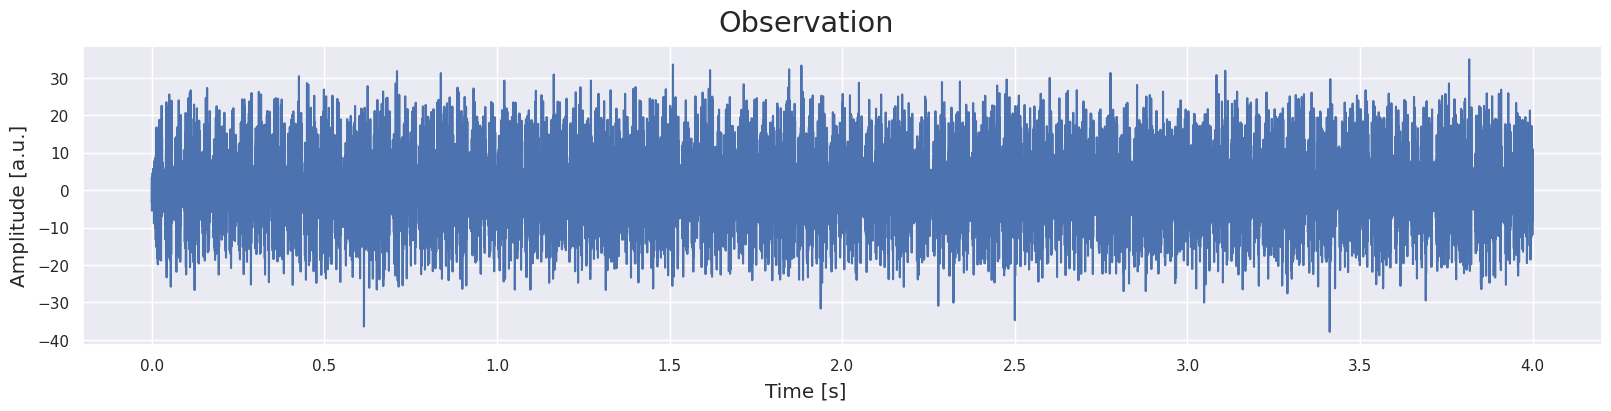

In [25]:
L = int(round(20e-3 * SIG_FS))  # kernel length
print("Kernel length:", L)

A = prng.standard_normal(size=(L,), dtype=np.float32)
X = np.convolve(S, A, mode="same")

emgkit.plotting.plot_signal(
    X,
    fs=SIG_FS,
    style="complete",
    title="Observation",
    fig_size=(16, 4),
)

Alternatively, one can obtain the observations by:
- extending the source signal, stacking as many delayed replicas as the discrete length of the kernel;
- do a vector-matrix multiplication between the kernel and the extended sources.

Shape of the vector of extended sources: (15921, 80)


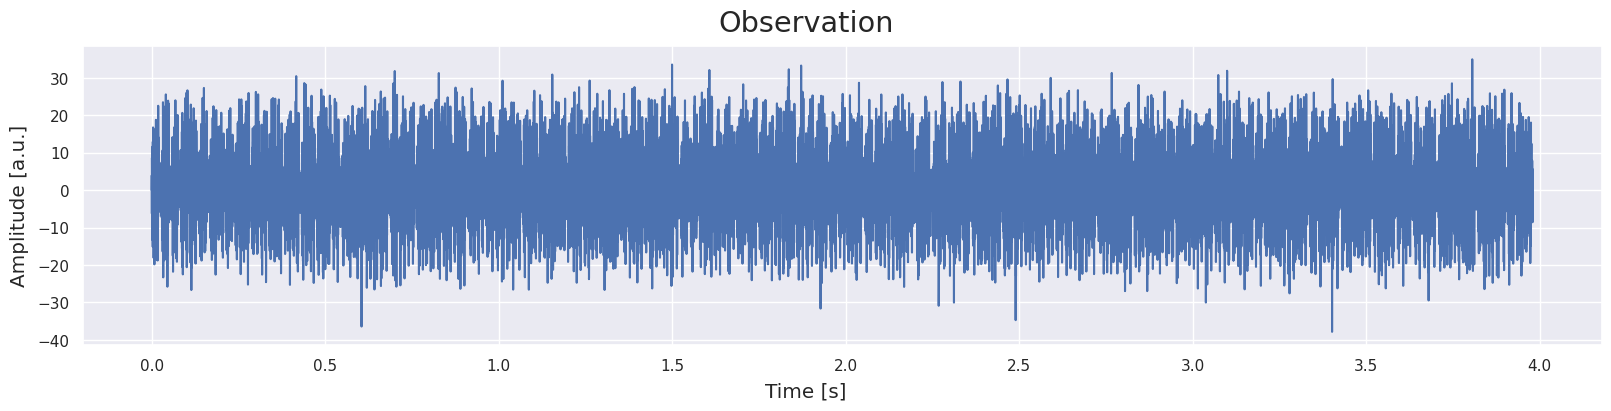

In [26]:
S_ext = emgkit.preprocessing.extend_signal(S, f_ext=L)
print("Shape of the vector of extended sources:", S_ext.shape)

X = S_ext @ A.T
emgkit.plotting.plot_signal(
    X,
    fs=SIG_FS,
    style="complete",
    title="Observation",
    fig_size=(16, 4),
)

However, we now have only a single observation. To apply FastICA, we must extend both the source and the observation by choosing an extension factor $f_\text{ext}$:
- we extend the source by stacking $L + f_\text{ext} - 1$ delayed replicas;
- we create an $f_\text{ext} \times (L + f_\text{ext} - 1)$ mixing matrix, containing delayed version of the kernel;
- we multiply them, obtaining $f_\text{ext}$ delayed replicas of the observations.

Extension factor: 120


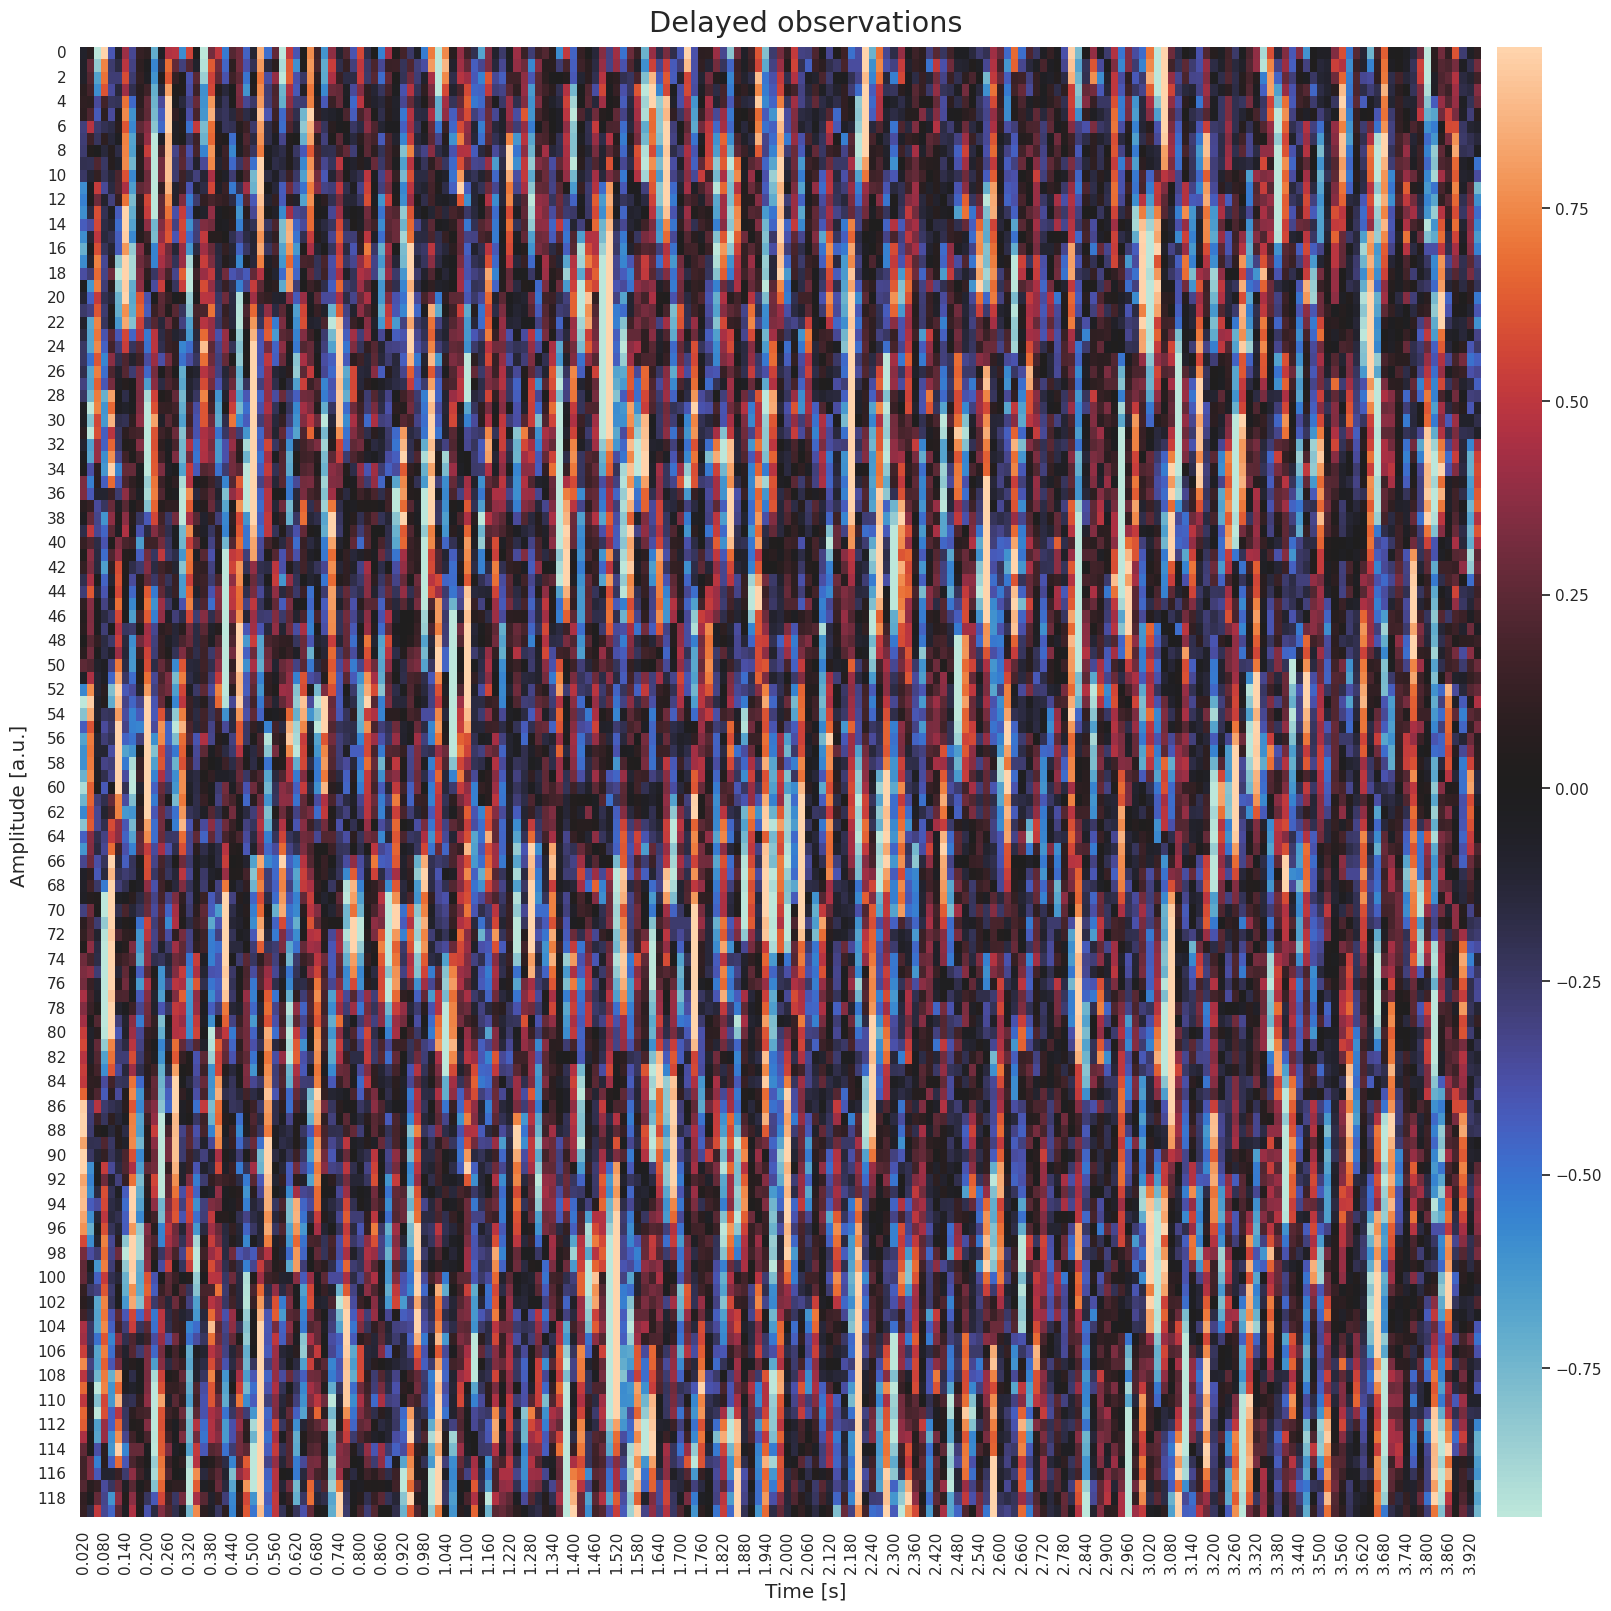

In [27]:
f_ext = int(round(30e-3 * SIG_FS))  # extension factor
print("Extension factor:", f_ext)

# Extension
S_ext = emgkit.preprocessing.extend_signal(S, L + f_ext - 1)
A_ext = np.zeros(shape=(f_ext, L + f_ext - 1), dtype=np.float32)
for i in range(f_ext):
    A_ext[i, i : i + L] = A
X_ext = S_ext @ A_ext.T

emgkit.plotting.plot_signal(
    X_ext,
    fs=SIG_FS,
    style="compact",
    title="Delayed observations",
    fig_size=(16, 16),
    resolution=80,  # 20ms
)

Let's verify that the uncorrelation assumption still holds.

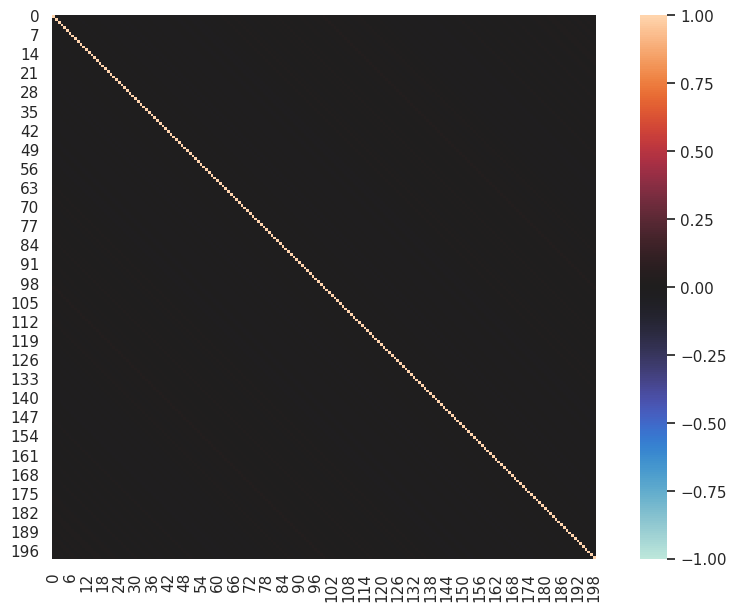

In [28]:
emgkit.plotting.plot_correlation(S_ext, fig_size=(9, 6))

Now, let's whiten the observations (using either ZCA or PCA) and run FastICA with 20 target components.

INFO:root:Instantiating FastICA using "symmetric" strategy and "skewness" contrast function.
INFO:root:Instantiating ZCAWhitening using "svd" solver.
INFO:root:FastICA iteration 1: 9.991e-01.
INFO:root:FastICA iteration 2: 4.465e-01.
INFO:root:FastICA iteration 3: 1.948e-01.
INFO:root:FastICA iteration 4: 6.790e-02.
INFO:root:FastICA iteration 5: 3.740e-02.
INFO:root:FastICA iteration 6: 3.762e-02.
INFO:root:FastICA iteration 7: 3.015e-02.
INFO:root:FastICA iteration 8: 2.993e-02.
INFO:root:FastICA iteration 9: 2.925e-02.
INFO:root:FastICA iteration 10: 4.120e-03.
INFO:root:FastICA iteration 11: 2.664e-05.
INFO:root:FastICA converged after 11 iterations, the distance is: 2.664e-05.
INFO:root:Performing saddle test...


INFO:root:Saddle point test ok.


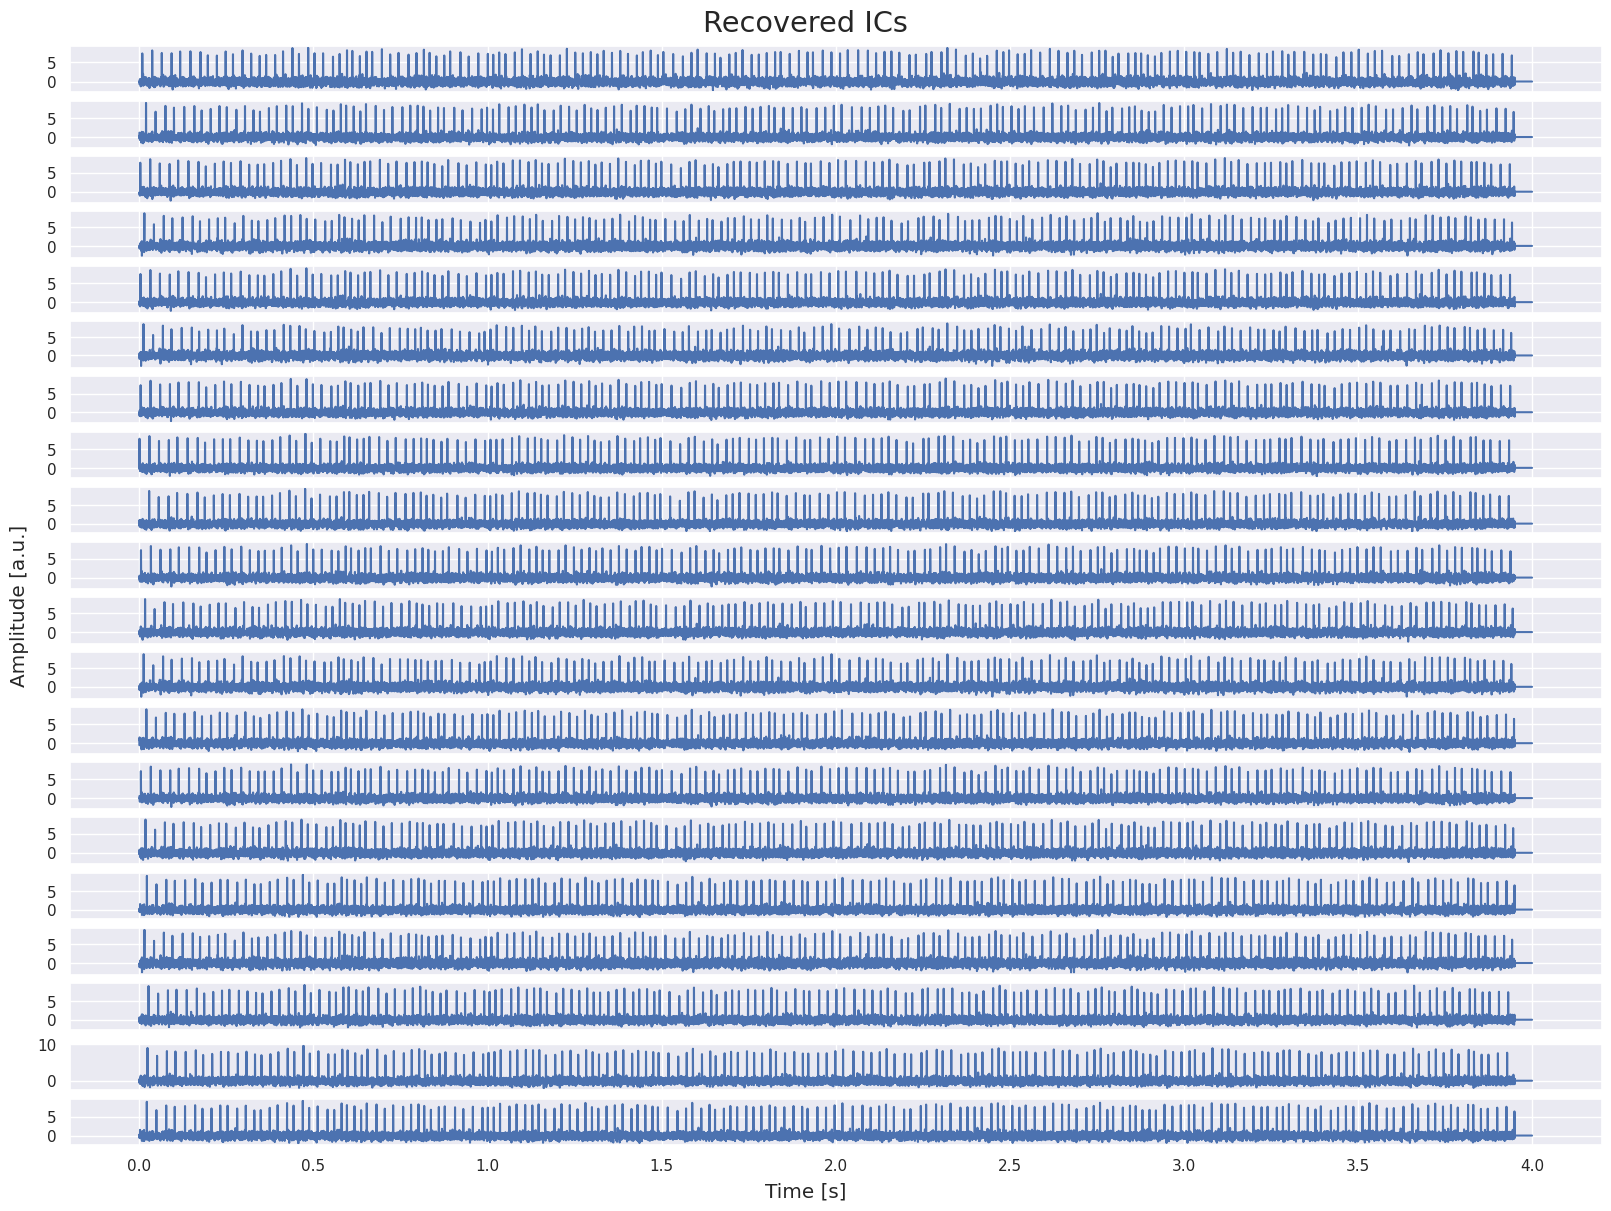

In [29]:
S_rec, ica_model = emgkit.ica.fast_ica(
    X_ext,
    n_ics=20,
    g_name="skewness",
    do_saddle_test=True,
    device=device,
    seed=SEED,
)
S_rec = torch.nn.functional.pad(S_rec, (0, 0, 0, L + f_ext - 2))  # pad

emgkit.plotting.plot_signal(
    S_rec,
    fs=SIG_FS,
    style="complete",
    title="Recovered ICs",
    fig_size=(16, 12),
)

To check if the estimated sources are correct, let's extract spikes from both the original source and the estimated ones and compare their number.

In [30]:
# Extract spikes
S_spikes_t = {"IC0": emgkit.utils.detect_spikes(S)[0] / SIG_FS}
S_spikes_bin = emgkit.utils.sparse_to_dense(S_spikes_t, SIG_LEN, SIG_FS)
S_rec_spikes_t = {
    f"IC{i}": emgkit.utils.detect_spikes(S_rec[:, i])[0] / SIG_FS
    for i in range(S_rec.size(1))
}
S_rec_spikes_bin = emgkit.utils.sparse_to_dense(S_rec_spikes_t, SIG_LEN, SIG_FS)

delays = {}
for ic in S_rec_spikes_bin:
    _, delay, tp, fp, fn = emgkit.utils.check_delayed_pair(
        S_spikes_bin["IC0"].to_numpy(),
        S_rec_spikes_bin[ic].to_numpy(),
        fs=SIG_FS,
        tol_ms=0.5,
        min_perc=0.3,
    )
    delays[ic] = delay / SIG_FS

    # Compute metrics
    roa = tp / (tp + fn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    print(f"{ic}: delay of {delay} samples.")
    print(f"\tRoA = {roa:.2%}\tPrecision = {precision:.2%}\tRecall = {recall:.2%}")

IC0: delay of -47 samples.
	RoA = 98.86%	Precision = 100.00%	Recall = 98.86%
IC1: delay of -118 samples.
	RoA = 98.86%	Precision = 100.00%	Recall = 98.86%
IC2: delay of -70 samples.
	RoA = 98.86%	Precision = 100.00%	Recall = 98.86%
IC3: delay of -137 samples.
	RoA = 98.86%	Precision = 100.00%	Recall = 98.86%
IC4: delay of -68 samples.
	RoA = 98.86%	Precision = 100.00%	Recall = 98.86%
IC5: delay of -147 samples.
	RoA = 98.86%	Precision = 100.00%	Recall = 98.86%
IC6: delay of -66 samples.
	RoA = 98.86%	Precision = 100.00%	Recall = 98.86%
IC7: delay of -79 samples.
	RoA = 98.86%	Precision = 100.00%	Recall = 98.86%
IC8: delay of -82 samples.
	RoA = 98.30%	Precision = 100.00%	Recall = 98.30%
IC9: delay of -62 samples.
	RoA = 98.86%	Precision = 100.00%	Recall = 98.86%
IC10: delay of -129 samples.
	RoA = 98.86%	Precision = 100.00%	Recall = 98.86%
IC11: delay of -145 samples.
	RoA = 98.86%	Precision = 100.00%	Recall = 98.86%
IC12: delay of -114 samples.
	RoA = 98.86%	Precision = 100.00%	Recall

The estimated sources are indeed reliable.

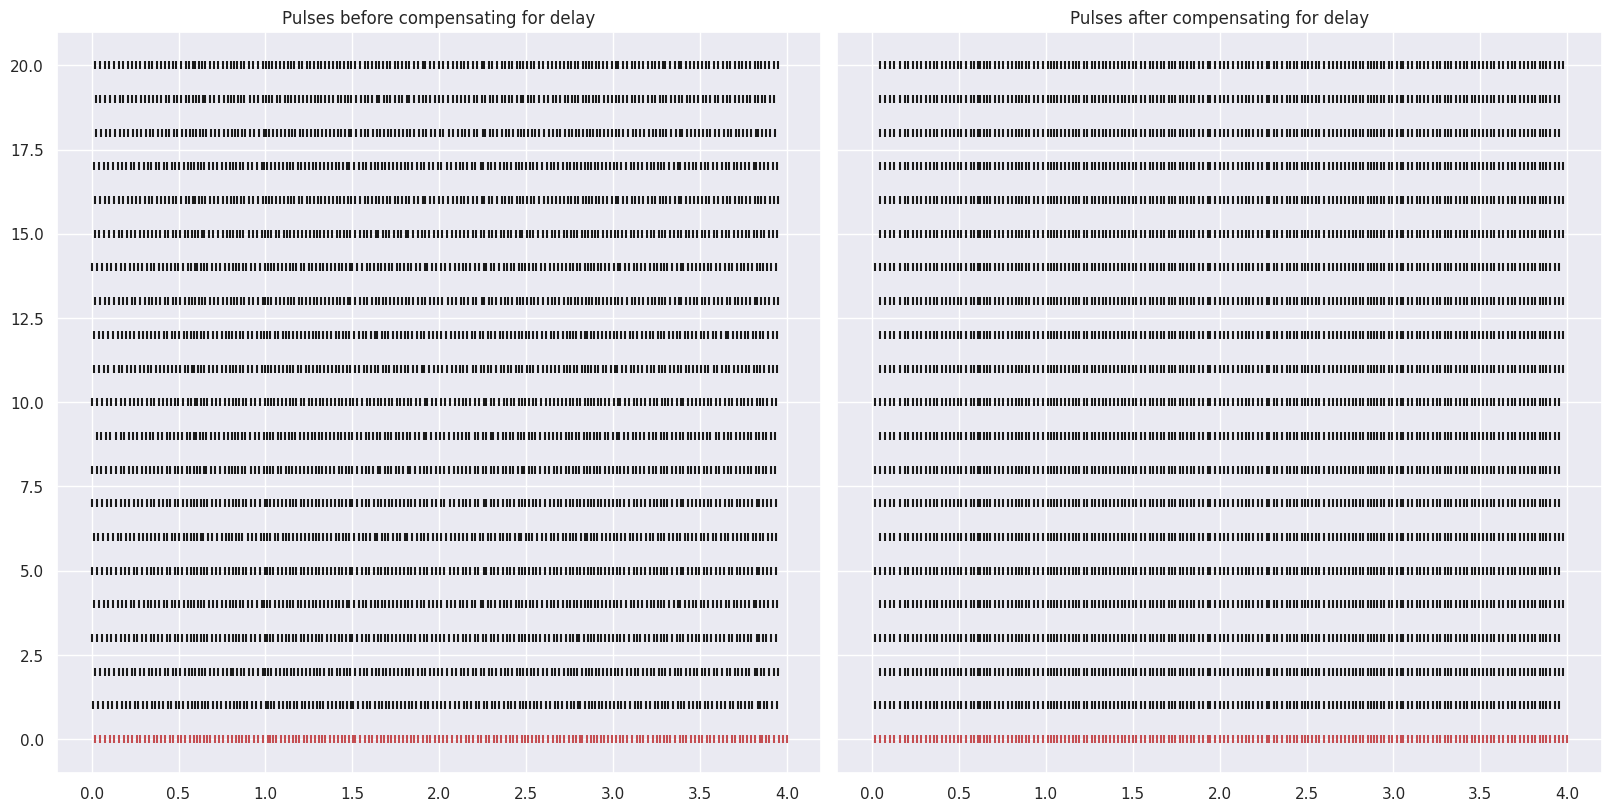

In [31]:
_, axes = plt.subplots(
    nrows=1,
    ncols=2,
    sharex="all",
    sharey="all",
    figsize=(16, 8),
    layout="constrained",
)

axes[0].set_title("Pulses before compensating for delay")
axes[0].scatter(
    x=S_spikes_t["IC0"],
    y=[0] * S_spikes_t["IC0"].size,
    marker="|",
    color="r",
)
axes[1].set_title("Pulses after compensating for delay")
axes[1].scatter(
    x=S_spikes_t["IC0"],
    y=[0] * S_spikes_t["IC0"].size,
    marker="|",
    color="r",
)
for i, ic in enumerate(S_rec_spikes_t.keys()):
    axes[0].scatter(
        x=S_rec_spikes_t[ic],
        y=[i + 1] * S_rec_spikes_t[ic].size,
        marker="|",
        color="k",
    )
    axes[1].scatter(
        x=S_rec_spikes_t[ic] - delays[ic],
        y=[i + 1] * S_rec_spikes_t[ic].size,
        marker="|",
        color="k",
    )
plt.show()